# ADHD200 — Обучение (Multiclass) на подготовленных таймсериях - Iter 2

Этот ноутбук реализует три ступени:
1) **Базлайны без нейросетей**:
   - **Статический FC** (корреляции ROI×ROI) → Logistic Regression (+PCA по желанию);
   - **Динамический FC + HMM** (или KMeans), признаки: доли состояний, переключаемость, длительность.
   - **Переносимость**: Leave-One-Site-Out для статического FC.
2) **Нейросети**: LSTM/GRU/TCN+BiGRU+Self-Attn с ковариатами (возраст/пол), веса классов, метрики `acc/auc/f1`.
3) **Строгая валидация**: групповой сплит по участнику/сайту для предотвращения утечек.

В данном ноутбуке используется подготовленный набор данных из ноутбука [ADHD200_prep.ipynb](ADHD200_prep.ipynb). Для обучения нейросети используются файлы `.npy` с таймсериями. Обучение ведётся только на данных подростков из соответствующего отфильтрованного манифеста `manifest.csv`.


In [43]:
%pip install torch
%pip install hmmlearn

import re, os
from pathlib import Path

import numpy as np
import pandas as pd

from IPython.display import display

from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve

from hmmlearn.hmm import GaussianHMM

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Plotting
import matplotlib.pyplot as plt

# Увеличим ширину печати для pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Отключим предупреждения для чистоты логирования
import warnings
warnings.filterwarnings('ignore')

python(45668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


python(45690) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


## Конфигурация

In [48]:
DATA_ROOT = './Athena_prepared_filtered/cohort_teen_participants'
MANIFEST_CSV = f'{DATA_ROOT}/manifest_windows.csv'
DFC_CSV      = f'{DATA_ROOT}/dfc_features.csv'   # если генерировались dFC-признаки

PHENO_CSV = "../SortedRawDataBIDS/cohort_teen_participants/participants.tsv"    # participant_id + метка (0..N_CLASSES-1) + Age + sex + site
DATA_MODE = 'SEQ_NPY'  # 'SEQ_NPY' | 'SEQ_TSV' | 'DFC'

CHECKPOINT_DIR = str(Path(DATA_ROOT)/'iter_2_checkpoints')

REUSE_MODELS = False
N_CLASSES = 4                         # число классов для классификации (0 - TD, 1 - ADHD-C, 2 - ADHD-HI, 3 - ADHD-I)
EPOCHS = 50
BATCH_TRAIN = 32
BATCH_VAL = 64
LR = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
BATCH_SIZE = 16

# === Early Stopping ===
EARLY_STOP_PATIENCE = 15
EARLY_STOP_METRIC   = 'val_loss'
MIN_DELTA_IMPROVE   = 1e-4

# === Санитизация и стабильность ===
SANITIZE_INPUTS = True
ADD_EPS_NOISE_IF_ALL_ZERO = True
MAX_GRAD_NORM = 5.0
REINIT_ON_NAN = True
STAGNATION_RESET_EPOCHS = 3
HEAD_REINIT = True

# === NaN / Imputation handling (salvage) ===
IMPUTE_STRATEGY = 'roi_mean'          # 'roi_mean' | 'global_zero'
SAMPLE_MAX_NAN_FRAC = 0.98            # итоговый порог после salvage
ROW_MIN_FINITE_FRAC = 0.3             # ослаблен: строка валидна если >=30% конечных
DROP_HIGH_NAN = True                  # удалять примеры только если нан_frac==1.0 (полностью испорчены)
LOG_NAN_STATS = True
ROI_DROP_THRESHOLD = 0.2              # удалить ROI (столбец), если доля конечных значений <20% в примере
INTERPOLATE_NAN = True                # линейная интерполяция по времени до mean-импутации

# === Балансировка классов ===
ENABLE_AUTOBALANCE = True
BALANCE_STRATEGY = 'sampler'          
CLASS_WEIGHT_MODE = 'inv_freq'
MAX_CLASS_WEIGHT_RATIO = 10.0         # ограничение максимального веса класса

LABEL_COLUMN_CANDIDATES = ['label','Label','DX','dx','Diagnosis','diagnosis']
BINARY_MAP = {0:0, 1:1, 2:2, 3:3, 'ADHD-Combined':1, 'ADHD-Hyperactive/Impulsive':2, 'ADHD-Inattentive':3, 'TD':0, 'HC':0, 'Control':0}
MULTICLASS = True

USE_COVARIATES = False
COV_CONT = ['age']
COV_CAT  = ['sex','site']

RUN_BASELINES = True
FC_PCA_COMPONENTS = 200
HMM_N_STATES = 5
WIN_DYN = 30
STEP_DYN = 5
DO_LOSO = True
VAL_SIZE = 0.2                        # доля валидационного сета при GroupShuffleSplit - 20%

torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Обучение моделей будет произведено на {DEVICE}")
print(f"EarlyStopping: metric={EARLY_STOP_METRIC}, patience={EARLY_STOP_PATIENCE}")
print(f"Sanitize={SANITIZE_INPUTS}, GradClip={MAX_GRAD_NORM}, ReinitOnNaN={REINIT_ON_NAN}, StagnationReset={STAGNATION_RESET_EPOCHS}")
print(f"Salvage: Impute={IMPUTE_STRATEGY}, SampleMaxNanFrac={SAMPLE_MAX_NAN_FRAC}, RowMinFiniteFrac={ROW_MIN_FINITE_FRAC}, ROI_drop<{ROI_DROP_THRESHOLD}, Interp={INTERPOLATE_NAN}")

Обучение моделей будет произведено на cpu
EarlyStopping: metric=val_loss, patience=15
Sanitize=True, GradClip=5.0, ReinitOnNaN=True, StagnationReset=3
Salvage: Impute=roi_mean, SampleMaxNanFrac=0.98, RowMinFiniteFrac=0.3, ROI_drop<0.2, Interp=True


## 1) Загрузка манифеста и фенотипов

In [3]:
man = pd.read_csv(MANIFEST_CSV)
ph  = pd.read_csv(PHENO_CSV, delimiter='\t') # для .tsv

if 'participant_id' not in ph.columns:
    for c in ph.columns:
        if c.lower() in ('participant_id','subject','sub','id'):
            ph = ph.rename(columns={c:'participant_id'})
            break

label_col = next((c for c in LABEL_COLUMN_CANDIDATES if c in ph.columns), None)
assert label_col is not None, f'Нет метки среди: {LABEL_COLUMN_CANDIDATES}'

ph = ph[['participant_id', label_col] + [c for c in COV_CONT+COV_CAT if c in ph.columns]].copy()
ph.rename(columns={label_col:'label'}, inplace=True)
if not MULTICLASS:
    ph['label'] = ph['label'].map(BINARY_MAP)

man.shape, ph.shape


((660, 14), (274, 5))

In [4]:
man.head()

,participant_id,pid_raw,site,site_original,run_id,win_index,segment_start,segment_end,npy_path,mask_path,tsv_path,atlas,TR,nan_ratio_run
0,sub-kki1018959,1018959,kki,KKI,ses1_rest1,0,0,200,Athena_prepared_filtered/cohort_teen_participa...,Athena_prepared_filtered/cohort_teen_participa...,NaN,CC400,NaN,0.0
1,sub-kki1019436,1019436,kki,KKI,ses1_rest1,0,0,200,Athena_prepared_filtered/cohort_teen_participa...,Athena_prepared_filtered/cohort_teen_participa...,NaN,CC400,NaN,0.0
2,sub-kki1594156,1594156,kki,KKI,ses1_rest1,0,0,200,Athena_prepared_filtered/cohort_teen_participa...,Athena_prepared_filtered/cohort_teen_participa...,NaN,CC400,NaN,0.0
3,sub-kki1623716,1623716,kki,KKI,ses1_rest1,0,0,200,Athena_prepared_filtered/cohort_teen_participa...,Athena_prepared_filtered/cohort_teen_participa...,NaN,CC400,NaN,0.0
4,sub-kki2026113,2026113,kki,KKI,ses1_rest1,0,0,200,Athena_prepared_filtered/cohort_teen_participa...,Athena_prepared_filtered/cohort_teen_participa...,NaN,CC400,NaN,0.0


In [5]:
ph.head()

,participant_id,label,age,sex,site
0,sub-kki2026113,1,12.99,F,KKI
1,sub-kki1623716,1,12.65,F,KKI
2,sub-kki1594156,0,12.87,M,KKI
3,sub-kki2917777,0,12.66,M,KKI
4,sub-kki1018959,0,12.36,F,KKI


## 2) Таблица примеров под режим

Эта функция строит DataFrame с примерами для заданного режима работы модели (например, `SEQ_NPY` для таймсерий в формате `.npy`).

In [6]:
def build_table_for_mode(manifest, phenotypes, mode):
    df = manifest.copy()
    if mode=='SEQ_NPY':
        df = df[df['npy_path'].notna() & df['npy_path'].astype(str).str.len()>0]
        df['data_path'] = df['npy_path']
    elif mode=='SEQ_TSV':
        if 'tsv_path' not in df.columns: raise ValueError("Нет 'tsv_path' в манифесте")
        df = df[df['tsv_path'].notna() & df['tsv_path'].astype(str).str.len()>0]
        df['data_path'] = df['tsv_path']
    elif mode=='DFC':
        dfc = pd.read_csv(DFC_CSV)
        agg = (manifest.groupby('participant_id').agg({'site':'first','atlas':'first','TR':'median'}).reset_index())
        df = dfc.merge(agg, on='participant_id', how='left')
    else:
        raise ValueError('Unknown mode')
    df = df.merge(phenotypes, on='participant_id', how='inner')
    df = df[df['label'].notna()].reset_index(drop=True)
    return df

data_df = build_table_for_mode(man, ph, DATA_MODE)
data_df.head()


,participant_id,pid_raw,site_x,site_original,run_id,win_index,segment_start,segment_end,npy_path,mask_path,tsv_path,atlas,TR,nan_ratio_run,data_path,label,age,sex,site_y
0,sub-kki1018959,1018959,kki,KKI,ses1_rest1,0,0,200,Athena_prepared_filtered/cohort_teen_participa...,Athena_prepared_filtered/cohort_teen_participa...,NaN,CC400,NaN,0.0,Athena_prepared_filtered/cohort_teen_participa...,0,12.36,F,KKI
1,sub-kki1019436,1019436,kki,KKI,ses1_rest1,0,0,200,Athena_prepared_filtered/cohort_teen_participa...,Athena_prepared_filtered/cohort_teen_participa...,NaN,CC400,NaN,0.0,Athena_prepared_filtered/cohort_teen_participa...,3,12.98,M,KKI
2,sub-kki1594156,1594156,kki,KKI,ses1_rest1,0,0,200,Athena_prepared_filtered/cohort_teen_participa...,Athena_prepared_filtered/cohort_teen_participa...,NaN,CC400,NaN,0.0,Athena_prepared_filtered/cohort_teen_participa...,0,12.87,M,KKI
3,sub-kki1623716,1623716,kki,KKI,ses1_rest1,0,0,200,Athena_prepared_filtered/cohort_teen_participa...,Athena_prepared_filtered/cohort_teen_participa...,NaN,CC400,NaN,0.0,Athena_prepared_filtered/cohort_teen_participa...,1,12.65,F,KKI
4,sub-kki2026113,2026113,kki,KKI,ses1_rest1,0,0,200,Athena_prepared_filtered/cohort_teen_participa...,Athena_prepared_filtered/cohort_teen_participa...,NaN,CC400,NaN,0.0,Athena_prepared_filtered/cohort_teen_participa...,1,12.99,F,KKI


In [7]:
# === Salvage & Filtering pass (replaces previous hard drop logic) ===
if DATA_MODE in ('SEQ_NPY','SEQ_TSV'):
    nan_fracs = []
    roi_drop_counts = []
    sample_paths = data_df['data_path'].tolist()
    for p in sample_paths:
        try:
            arr = np.load(p) if DATA_MODE=='SEQ_NPY' else pd.read_csv(p, sep='\t', header=None, compression='gzip').values
            fin = np.isfinite(arr)
            nan_frac = 1.0 - fin.mean()
            # ROI salvage: drop columns (ROIs) with too few finite values
            col_finite_ratio = fin.mean(axis=0)
            bad_cols = np.where(col_finite_ratio < ROI_DROP_THRESHOLD)[0]
            roi_drop_counts.append(len(bad_cols))
            if len(bad_cols)>0 and len(bad_cols) < arr.shape[1]:
                arr = np.delete(arr, bad_cols, axis=1)
            # recompute nan_frac after column drop
            fin2 = np.isfinite(arr)
            nan_frac = 1.0 - fin2.mean()
        except Exception:
            nan_frac = 1.0
            roi_drop_counts.append(np.nan)
        nan_fracs.append(nan_frac)
    data_df['nan_frac_raw'] = nan_fracs
    data_df['roi_drop_cnt'] = roi_drop_counts
    if LOG_NAN_STATS:
        print('[Salvage] Raw nan_frac describe:')
        print(data_df['nan_frac_raw'].describe())
        print('[Salvage] ROI drop count describe:')
        print(data_df['roi_drop_cnt'].describe())
    # Drop only fully corrupted samples (nan_frac_raw == 1.0)
    if DROP_HIGH_NAN:
        before = len(data_df)
        data_df = data_df[data_df['nan_frac_raw'] < 1.0].reset_index(drop=True)
        print(f"[Salvage] Dropped {before - len(data_df)} fully NaN samples")
    # Recompute simple histogram
    if LOG_NAN_STATS:
        import numpy as np
        hist_vals = data_df['nan_frac_raw'].values
        bins = np.linspace(0,1,11)
        hist, _ = np.histogram(hist_vals, bins=bins)
        print('[Salvage] nan_frac histogram (bins 0..1 step 0.1):', hist)
else:
    print('[Salvage] Skipped (DFC mode)')
print('Размер после salvage:', data_df.shape)

[Salvage] Raw nan_frac describe:
count    372.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: nan_frac_raw, dtype: float64
[Salvage] ROI drop count describe:
count    372.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: roi_drop_cnt, dtype: float64
[Salvage] Dropped 0 fully NaN samples
[Salvage] nan_frac histogram (bins 0..1 step 0.1): [372   0   0   0   0   0   0   0   0   0]
Размер после salvage: (372, 21)


In [8]:
# === Фильтрация примеров по доле NaN до сплитов ===
if DATA_MODE in ('SEQ_NPY','SEQ_TSV'):
    nan_fracs = []
    for p in data_df['data_path']:
        try:
            arr = np.load(p) if DATA_MODE=='SEQ_NPY' else pd.read_csv(p, sep='\t', header=None, compression='gzip').values
            total = arr.size
            nan_count = np.isnan(arr).sum()
            nan_frac = nan_count / total
        except Exception as e:
            nan_frac = 1.0
        nan_fracs.append(nan_frac)
    data_df['nan_frac'] = nan_fracs
    if LOG_NAN_STATS:
        print('[NaN] Summary before filtering:')
        print(data_df['nan_frac'].describe())
        print('[NaN] Count > SAMPLE_MAX_NAN_FRAC:', (data_df['nan_frac']>SAMPLE_MAX_NAN_FRAC).sum())
    if DROP_HIGH_NAN:
        kept_df = data_df[data_df['nan_frac']<=SAMPLE_MAX_NAN_FRAC].reset_index(drop=True)
        dropped = len(data_df)-len(kept_df)
        print(f"[NaN] Dropped {dropped} / {len(data_df)} samples (>{SAMPLE_MAX_NAN_FRAC*100:.1f}% NaN)")
        data_df = kept_df
else:
    print('[NaN] Skipped filtering (DFC mode)')

print('Размер после NaN фильтрации:', data_df.shape)
print('Top nan_frac head:')
print(data_df[['data_path','nan_frac']].head())

[NaN] Summary before filtering:
count    372.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: nan_frac, dtype: float64
[NaN] Count > SAMPLE_MAX_NAN_FRAC: 0
[NaN] Dropped 0 / 372 samples (>98.0% NaN)
Размер после NaN фильтрации: (372, 22)
Top nan_frac head:
                                           data_path  nan_frac
0  Athena_prepared_filtered/cohort_teen_participa...       0.0
1  Athena_prepared_filtered/cohort_teen_participa...       0.0
2  Athena_prepared_filtered/cohort_teen_participa...       0.0
3  Athena_prepared_filtered/cohort_teen_participa...       0.0
4  Athena_prepared_filtered/cohort_teen_participa...       0.0


In [9]:
paths = data_df['data_path'].head(10).tolist()
for p in paths:
    x = np.load(p)
print(p, 'nan%', np.isnan(x).mean()*100, 'std_mean', x.std(axis=0).mean())

Athena_prepared_filtered/cohort_teen_participants/sub-nyu0010002/sub-nyu0010002_ses1_rest1_w0_CC400.npy nan% 0.0 std_mean 0.9247843


## 3) Сплиты без утечки и ковариаты

Эта функция создаёт сплиты по участникам/сайтам, чтобы избежать утечек между обучением и валидацией. Также она извлекает ковариаты (возраст, пол) для использования в модели.

In [10]:
groups = data_df['participant_id'].astype(str).values
y = data_df['label'].values
if len(np.unique(y))>1:
    splitter = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
else:
    splitter = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
folds = list(splitter.split(X=np.zeros_like(y), y=y, groups=groups))

cov_cols_cont = [c for c in COV_CONT if c in data_df.columns]
cov_cols_cat  = [c for c in COV_CAT  if c in data_df.columns]
if USE_COVARIATES and (cov_cols_cont or cov_cols_cat):
    pre = ColumnTransformer([
        ('cont', StandardScaler(), cov_cols_cont),
        ('cat',  OneHotEncoder(handle_unknown='ignore'), cov_cols_cat)
    ])
else:
    pre = None

# Выведем информацию о разбиении и ковариатах
print(f"Для текущего разбиения: длина {len(folds)}")
if USE_COVARIATES:
    print(f"Числовые ковариаты - {cov_cols_cont}, категориальные ковариаты - {cov_cols_cat}")
else:
    print("Ковариаты не используются.")

Для текущего разбиения: длина 5
Ковариаты не используются.


## 4) Датасеты и DataLoader’ы

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, mode, cov_pre=None):
        assert mode in ('SEQ_NPY','SEQ_TSV')
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.cov_pre = cov_pre
        if cov_pre is not None:
            cov_input = self.df[[c for c in (cov_cols_cont+cov_cols_cat) if c in self.df.columns]].copy()
            self.cov = cov_pre.transform(cov_input)
            self.cov = np.asarray(self.cov, dtype=np.float32)
        else:
            self.cov = None
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        if self.mode=='SEQ_NPY':
            x = np.load(r['data_path']).astype('float32')
        else:
            x = pd.read_csv(r['data_path'], sep='\t', header=None, compression='gzip').values.astype('float32')
        # NaN stats per sample for debug (not persisted each call to avoid slowdown)
        finite_mask = np.isfinite(x)
        # Build time mask: row valid if fraction finite >= ROW_MIN_FINITE_FRAC
        row_valid = (finite_mask.sum(axis=1) / finite_mask.shape[1]) >= ROW_MIN_FINITE_FRAC
        # Impute NaNs
        if IMPUTE_STRATEGY == 'roi_mean':
            # Compute ROI means over valid rows (avoid NaNs)
            roi_means = np.where(np.isfinite(x[row_valid]).sum(axis=0)>0, np.nanmean(x[row_valid], axis=0), 0.0)
            # Replace NaNs with corresponding roi mean
            nan_positions = ~finite_mask
            x[nan_positions] = np.take(roi_means, np.where(nan_positions)[1])
        else:  # global_zero
            x[~finite_mask] = 0.0
        if ADD_EPS_NOISE_IF_ALL_ZERO and not np.any(x):
            x += (np.random.randn(*x.shape).astype('float32')) * 1e-3
        # Final sanitize
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        m = row_valid.astype('float32')  # mask of valid timepoints
        # If external mask exists, AND it
        mpath = r.get('mask_path', None)
        if isinstance(mpath, str) and len(mpath)>0 and Path(mpath).exists():
            ext_m = np.load(mpath).astype('float32')
            if ext_m.shape[0] == m.shape[0]:
                m = m * ext_m
        if self.cov is not None:
            cov_t = torch.from_numpy(self.cov[i])
        else:
            cov_t = torch.empty(0)
        y = int(r['label'])
        pid = str(r['participant_id'])
        return torch.from_numpy(x), torch.from_numpy(m), cov_t, torch.tensor(y), pid

class DFCDataset(Dataset):
    def __init__(self, df, cov_pre=None):
        self.df = df.reset_index(drop=True)
        self.cov_pre = cov_pre
        drop_cols = {'participant_id','site','atlas','TR','label'}
        self.feat_cols = [c for c in self.df.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(self.df[c])]
        if cov_pre is not None:
            cov_input = self.df[[c for c in (cov_cols_cont+cov_cols_cat) if c in self.df.columns]].copy()
            self.cov = cov_pre.transform(cov_input)
            self.cov = np.asarray(self.cov, dtype=np.float32)
        else:
            self.cov = None
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        x = self.df.loc[i, self.feat_cols].values.astype('float32')
        if IMPUTE_STRATEGY == 'roi_mean':  # treat each feature individually
            if not np.isfinite(x).all():
                bad = ~np.isfinite(x)
                x[bad] = 0.0  # cannot compute per-feature mean without temporal axis
        else:
            x[~np.isfinite(x)] = 0.0
        if ADD_EPS_NOISE_IF_ALL_ZERO and not np.any(x):
            x += (np.random.randn(*x.shape).astype('float32')) * 1e-3
        if self.cov is not None:
            cov_t = torch.from_numpy(self.cov[i])
        else:
            cov_t = torch.empty(0)
        y = int(r['label'])
        pid = str(r['participant_id'])
        return torch.from_numpy(x), torch.tensor(1.0), cov_t, torch.tensor(y), pid

# Oversampling helper (replicate minority rows)
def oversample_df(df, label_col='label'):
    counts = df[label_col].value_counts()
    max_n = counts.max()
    parts = []
    for lab, cnt in counts.items():
        subset = df[df[label_col]==lab]
        if cnt == max_n:
            parts.append(subset)
        else:
            reps = int(np.ceil(max_n / cnt))
            augmented = pd.concat([subset]*reps, ignore_index=True).iloc[:max_n]
            parts.append(augmented)
    out = pd.concat(parts, ignore_index=True).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    return out

from torch.utils.data import WeightedRandomSampler

def make_fold_dataloaders(df, fold_idx=0, mode='SEQ_NPY', cov_pipeline=None):
    groups = df['participant_id'].astype(str).values
    y = df['label'].values
    class_counts = pd.Series(y).value_counts()
    base_splits = 5
    min_class = class_counts.min()
    n_splits = base_splits if min_class >= base_splits else max(2, int(min_class))
    if len(np.unique(y))>1 and n_splits >=2:
        splitter = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    else:
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    folds = list(splitter.split(X=np.zeros_like(y), y=y, groups=groups))
    if fold_idx >= len(folds):
        fold_idx = 0
    tr_idx, va_idx = folds[fold_idx]

    df_train = df.iloc[tr_idx].copy()
    df_val = df.iloc[va_idx].copy()

    if ENABLE_AUTOBALANCE and BALANCE_STRATEGY == 'oversample':
        df_train = oversample_df(df_train, label_col='label')

    if cov_pipeline is not None:
        cov_fitted = Pipeline(steps=cov_pipeline.steps) if hasattr(cov_pipeline,'steps') else cov_pipeline
        cov_fitted.fit(df_train[[c for c in (cov_cols_cont+cov_cols_cat) if c in df_train.columns]])
    else:
        cov_fitted = None

    if mode in ('SEQ_NPY','SEQ_TSV'):
        tr_ds = TimeSeriesDataset(df_train, mode, cov_pre=cov_fitted)
        va_ds = TimeSeriesDataset(df_val, mode, cov_pre=cov_fitted)
    else:
        tr_ds = DFCDataset(df_train, cov_pre=cov_fitted)
        va_ds = DFCDataset(df_val, cov_pre=cov_fitted)

    if ENABLE_AUTOBALANCE and BALANCE_STRATEGY == 'sampler':
        labels_train = df_train['label'].values
        counts_train = pd.Series(labels_train).value_counts()
        if CLASS_WEIGHT_MODE == 'inv_sqrt':
            raw_w = {lab: 1.0/np.sqrt(cnt) for lab,cnt in counts_train.items()}
        else:
            raw_w = {lab: 1.0/cnt for lab,cnt in counts_train.items()}
        w_vals = np.array(list(raw_w.values()))
        w_vals /= w_vals.min()
        ratio = w_vals.max()/w_vals.min()
        if ratio > MAX_CLASS_WEIGHT_RATIO:
            w_vals = w_vals / w_vals.max() * MAX_CLASS_WEIGHT_RATIO
        for i,(lab,_) in enumerate(raw_w.items()):
            raw_w[lab] = w_vals[i]
        sample_weights = np.array([raw_w[lab] for lab in labels_train], dtype=np.float64)
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, sampler=sampler)
    else:
        train_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)

    val_loader = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, val_loader

## 5) Модели: LSTM / GRU / MLP / TCN+BiGRU+Self-Attn (SE, FiLM) - ROISequenceNet
- **LSTM/GRU**: компактные RNN-блоки. Ковариаты (если есть) конкатенируются к финальному скрытому состоянию.
- **MLP**: полносвязная сеть по усреднённым по времени признакам (среднее/дисперсия по ROI).
- **ROISequenceNet (TCN+BiGRU+Attn+SE+FiLM)**: темпоральные свёртки (локальные паттерны) → двунаправленный GRU (дальние зависимости) → self-attention и SE-внимание по ROI; ковариаты подаются через FiLM.


In [44]:
def _final_timestep_from_packed(out_padded, lengths):
    # out_padded: (B, T_max, H*) после pad_packed_sequence
    # lengths: (B,) реальные длины (int64)
    idx = (lengths - 1).to(out_padded.device)                 # (B,)
    B = out_padded.size(0)
    return out_padded[torch.arange(B, device=out_padded.device), idx]  # (B, H*)

class SimpleLSTM(nn.Module):
    def __init__(self, n_rois, n_classes=2, cov_dim=0, hidden=128, num_layers=1,
                 bidir=False, dropout=0.2, use_pack=False):
        super().__init__()
        self.use_pack = use_pack
        self.lstm = nn.LSTM(
            input_size=n_rois, hidden_size=hidden, num_layers=num_layers,
            batch_first=True, bidirectional=bidir,
            dropout=dropout if num_layers > 1 else 0.0
        )
        d = hidden * (2 if bidir else 1)
        self.cov_proj = nn.Linear(cov_dim, d) if cov_dim > 0 else None
        self.head = nn.Sequential(
            nn.LayerNorm(d), nn.ReLU(), nn.Dropout(dropout), nn.Linear(d, n_classes)
        )

    def forward(self, x, mask=None, cov=None):
        # x: (B,T,R), mask: (B,T) in {0,1}
        if self.use_pack and mask is not None:
            lengths = mask.sum(dim=1).to(torch.int64).cpu()
            packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
            out, _ = self.lstm(packed)
            out_padded, _ = pad_packed_sequence(out, batch_first=True)  # (B,T_max,H*)
            h = _final_timestep_from_packed(out_padded, lengths)        # (B,H*)
        else:
            if mask is not None:
                x = x * mask.unsqueeze(-1)  # простой и быстрый вариант
            out, _ = self.lstm(x)           # (B,T,H*)
            h = out[:, -1]                  # берём последний таймстеп

        if cov is not None and self.cov_proj is not None:
            h = h + self.cov_proj(cov)
        return self.head(h)

class SimpleGRU(nn.Module):
    def __init__(self, n_rois, n_classes=2, cov_dim=0, hidden=128, num_layers=1,
                 bidir=False, dropout=0.2, use_pack=False):
        super().__init__()
        self.use_pack = use_pack
        self.gru = nn.GRU(
            input_size=n_rois, hidden_size=hidden, num_layers=num_layers,
            batch_first=True, bidirectional=bidir,
            dropout=dropout if num_layers > 1 else 0.0
        )
        d = hidden * (2 if bidir else 1)
        self.cov_proj = nn.Linear(cov_dim, d) if cov_dim > 0 else None
        self.head = nn.Sequential(
            nn.LayerNorm(d), nn.ReLU(), nn.Dropout(dropout), nn.Linear(d, n_classes)
        )

    def forward(self, x, mask=None, cov=None):
        # x: (B,T,R), mask: (B,T) in {0,1}
        if self.use_pack and mask is not None:
            lengths = mask.sum(dim=1).to(torch.int64).cpu()
            packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
            out, _ = self.gru(packed)
            out_padded, _ = pad_packed_sequence(out, batch_first=True)  # (B,T_max,H*)
            h = _final_timestep_from_packed(out_padded, lengths)        # (B,H*)
        else:
            if mask is not None:
                x = x * mask.unsqueeze(-1)
            out, _ = self.gru(x)
            h = out[:, -1]

        if cov is not None and self.cov_proj is not None:
            h = h + self.cov_proj(cov)
        return self.head(h)
    
class  SimpleMLP(nn.Module):  # для DFC
    def __init__(self, in_dim, n_classes=2, cov_dim=0, hidden=256, dropout=0.2):
        super().__init__()
        self.cov_proj = nn.Linear(cov_dim, hidden) if cov_dim>0 else None
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, n_classes)
        )
    def forward(self, x, mask=None, cov=None):
        out = self.net(x)
        if cov is not None and self.cov_proj is not None:
            out = out + self.cov_proj(cov)
        return out


# === Сложная многосоставная (целевая) модель TCN+BiGRU+Self-Attn (SE, FiLM) ===

class Chomp1d(nn.Module):
    def __init__(self, chomp_size): super().__init__(); self.chomp_size=chomp_size
    def forward(self, x): return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, dropout=0.1):
        super().__init__()
        pad = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=pad, dilation=dilation)
        self.chomp1 = Chomp1d(pad)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=pad, dilation=dilation)
        self.chomp2 = Chomp1d(pad)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self.down = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x):
        out = self.chomp1(self.conv1(x)); out = self.relu(out); out = self.dropout(out)
        out = self.chomp2(self.conv2(out)); out = self.relu(out); out = self.dropout(out)
        return self.relu(out + self.down(x))

class SE1D(nn.Module):
    def __init__(self, channels, r=8):
        super().__init__()
        self.fc1 = nn.Linear(channels, max(1, channels // r))
        self.fc2 = nn.Linear(max(1, channels // r), channels)
    def forward(self, x):
        s = x.mean(dim=2); w = torch.sigmoid(self.fc2(F.relu(self.fc1(s))))
        return x * w.unsqueeze(-1)

class FiLM(nn.Module):
    def __init__(self, cov_dim, feat_ch):
        super().__init__(); self.gamma = nn.Linear(cov_dim, feat_ch); self.beta = nn.Linear(cov_dim, feat_ch)
    def forward(self, x, z):
        g = self.gamma(z).unsqueeze(-1); b = self.beta(z).unsqueeze(-1); return x * (1 + g) + b

class MultiHeadTemporalAttention(nn.Module):
    def __init__(self, d_model, n_heads=4):
        super().__init__(); self.mha = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.ln = nn.LayerNorm(d_model); self.ff = nn.Sequential(nn.Linear(d_model,2*d_model), nn.ReLU(), nn.Linear(2*d_model,d_model))
    def forward(self, X, mask=None):
        key_padding_mask = (~mask.bool()) if mask is not None else None
        Y,_ = self.mha(X,X,X, key_padding_mask=key_padding_mask)
        X = self.ln(X+Y); Z = self.ln(X + self.ff(X))
        if mask is None: return Z.mean(dim=1)
        w = mask.float().unsqueeze(-1); return (Z*w).sum(dim=1)/(w.sum(dim=1)+1e-8)

class ROISequenceNet(nn.Module):
    def __init__(self, n_roi, n_classes=4, cov_dim=0, tcn_dropout=0.1, gru_hidden=128, attn_heads=4):
        super().__init__()
        self.film = FiLM(cov_dim, 128) if cov_dim>0 else None
        self.se1 = SE1D(n_roi)
        self.tcn = nn.Sequential(
            TemporalBlock(n_roi, 128, kernel_size=5, dilation=1, dropout=tcn_dropout),
            TemporalBlock(128, 128, kernel_size=5, dilation=2, dropout=tcn_dropout),
            TemporalBlock(128, 128, kernel_size=5, dilation=4, dropout=tcn_dropout),
        )
        self.se2 = SE1D(128)
        self.bigru = nn.GRU(input_size=128, hidden_size=128, batch_first=True, bidirectional=True)
        self.attn = MultiHeadTemporalAttention(d_model=256, n_heads=4)
        self.head = nn.Sequential(nn.Linear(256,128), nn.ReLU(), nn.Dropout(0.2), nn.Linear(128, n_classes))
    def forward(self, x, mask=None, z=None):
        x = x.transpose(1,2); x = self.se1(x)
        if self.film is not None and z is not None: x = self.film(x, z)
        x = self.tcn(x); x = self.se2(x); x = x.transpose(1,2)
        y,_ = self.bigru(x); emb = self.attn(y, mask=mask); return self.head(emb)

## 6) Обучение и метрики

### Организация обучения
- Используется стандартный цикл обучения PyTorch с оптимизатором Adam и планировщиком lr.ReduceLROnPlateau.
- Метрики: accuracy, precision, AUC, F1-score (макро).
- Веса классов учитываются в функции потерь (CrossEntropyLoss).
- Последовательно обучаем модели LSTM, GRU и ROISequenceNet, сравнивая их производительность на валидационном наборе.

In [13]:
# Универсальный класс тренировки модели
class Trainer:
    def __init__(self, model, train_dl, val_dl, class_counts: pd.Series, device, lr=1e-3, weight_decay=1e-4):
        self.model = model.to(device)
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.device = device
        self.class_labels = sorted(class_counts.index.tolist())
        self.class_count = len(self.class_labels)
        weights = (1.0 / (class_counts + 1e-9))
        weights = (weights / weights.sum()) * len(class_counts)
        class_weights = torch.tensor(weights.values, dtype=torch.float32).to(device)
        self.criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)

    def _forward_model(self, X, M, C):
        if C is not None and C.nelement() > 0:
            # Пытаемся вызвать с аргументом cov, fallback на z
            try:
                return self.model(X, mask=M, cov=C)
            except TypeError:
                return self.model(X, mask=M, z=C)
        else:
            return self.model(X, mask=M)

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        for batch in self.train_dl:
            # Поддержка различных форматов батча
            if len(batch) == 5:
                X, M, C, y, _ = batch
            elif len(batch) == 4:
                X, M, C, y = batch
            elif len(batch) == 3:
                X, C, y = batch
                M = None
            else:
                raise ValueError(f"Unexpected batch length: {len(batch)}")
            X = X.to(self.device)
            y = y.to(self.device)
            M = M.to(self.device) if M is not None else None
            C = C.to(self.device) if (C is not None and C.nelement() > 0) else None
            outputs = self._forward_model(X, M, C)
            loss = self.criterion(outputs, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * X.size(0)
        return total_loss / len(self.train_dl.dataset)

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        all_preds, all_labels, all_probs = [], [], []
        with torch.no_grad():
            for batch in self.val_dl:
                if len(batch) == 5:
                    X, M, C, y, _ = batch
                elif len(batch) == 4:
                    X, M, C, y = batch
                elif len(batch) == 3:
                    X, C, y = batch
                    M = None
                else:
                    raise ValueError(f"Unexpected batch length: {len(batch)}")
                X = X.to(self.device)
                y = y.to(self.device)
                M = M.to(self.device) if M is not None else None
                C = C.to(self.device) if (C is not None and C.nelement() > 0) else None
                outputs = self._forward_model(X, M, C)
                loss = self.criterion(outputs, y)
                total_loss += loss.item() * X.size(0)
                probs = F.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                all_probs.append(probs.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        all_probs = np.vstack(all_probs) if all_probs else np.zeros((0, self.class_count))
        accuracy = accuracy_score(all_labels, all_preds) if all_labels else float('nan')
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0) if all_labels else float('nan')
        try:
            auc = roc_auc_score(all_labels, all_probs, average='weighted', multi_class='ovr', labels=self.class_labels) if all_labels else float('nan')
        except ValueError:
            auc = float('nan')
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0) if all_labels else float('nan')
        return total_loss / len(self.val_dl.dataset), accuracy, precision, auc, f1

In [14]:
def train_one_epoch(model, opt, dl, device='cuda'):
    model.train(); losses=[]; ce=nn.CrossEntropyLoss()
    for xb, mb, cb, yb, _ in dl:
        xb=xb.to(device).float(); yb=yb.to(device).long(); cb=cb.to(device).float() if cb is not None else None
        if SANITIZE_INPUTS:
            xb = torch.nan_to_num(xb, nan=0.0, posinf=0.0, neginf=0.0)
        logits = model(xb, mask=mb, cov=cb)
        if torch.isnan(logits).any():
            print('[WARN] NaN logits detected, skipping batch')
            continue
        loss = ce(logits, yb)
        if torch.isnan(loss):
            print('[WARN] NaN loss detected, skipping batch')
            continue
        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        opt.step()
        losses.append(loss.item())
    return float(np.mean(losses)) if losses else float('nan')

@torch.no_grad()
def eval_metrics(model, dl, device='cuda'):
    model.eval(); ys=[]; yh=[]; yp=[]
    for xb, mb, cb, yb, _ in dl:
        xb=xb.to(device).float(); yb=yb.to(device).long(); cb=cb.to(device).float() if cb is not None else None
        if SANITIZE_INPUTS:
            xb = torch.nan_to_num(xb, nan=0.0, posinf=0.0, neginf=0.0)
        logits = model(xb, mask=mb, cov=cb)
        if torch.isnan(logits).any():
            continue
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        pred  = logits.argmax(dim=1).cpu().numpy().tolist()
        ys += yb.cpu().numpy().tolist(); yh += pred; yp += probs
    if not ys:
        return float('nan'), float('nan'), float('nan')
    acc = accuracy_score(ys, yh)
    try:
        if probs.shape[1] > 2:
            auc = roc_auc_score(ys, yp, multi_class='ovr')
        else:
            auc = roc_auc_score(ys, np.vstack(yp)[:,1])
    except Exception:
        auc = float('nan')
    f1  = f1_score(ys, yh, average='weighted')
    return acc, auc, f1

# Weight init helper
def init_weights_if_requested(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.uniform_(m.bias, -0.05, 0.05)
        elif isinstance(m, (nn.LSTM, nn.GRU)):
            for name, param in m.named_parameters():
                if 'weight' in name and param.ndimension() >= 2:
                    # use .data to avoid in-place ops on leaf views
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    # safe zero init
                    param.data.zero_()
                    # forget gate bias boost (only LSTM: bias_hh and bias_ih concatenated gates)
                    if isinstance(m, nn.LSTM):
                        hidden_size = m.hidden_size
                        # bias structure: [i, f, g, o]; set forget gate (f) to 1
                        param.data[hidden_size:2*hidden_size].fill_(1.0)

# Head reinit helper
def reinit_head(model):
    for name, module in model.named_modules():
        if name.endswith('head') and isinstance(module, nn.Sequential):
            for sub in module:
                if isinstance(sub, nn.Linear):
                    nn.init.xavier_uniform_(sub.weight)
                    if sub.bias is not None:
                        nn.init.uniform_(sub.bias, -0.05, 0.05)
            print('[INFO] Reinitialized classification head for stagnation recovery.')
            break

# Функция для обучения модели с поддержкой: history, early stopping, debug, санитизация, клиппинг, стагнация.

def train_model(model, train_dl, val_dl, class_counts, device, epochs=10, checkpoint_dir=None, lr=1e-3, weight_decay=1e-4, debug=False,
                early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE):
    if checkpoint_dir and not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir, exist_ok=True)
    trainer = Trainer(model, train_dl, val_dl, class_counts, device, lr, weight_decay)
    best_acc = 0.0
    history = []
    if early_metric not in ('val_loss','val_acc','val_f1'):
        early_metric = 'val_loss'
    early_best = None
    early_counter = 0

    init_weights_if_requested(model)
    stagnation_epochs = 0

    def param_vector(m):
        return torch.cat([p.detach().flatten() for p in m.parameters() if p.requires_grad])
    prev_params = param_vector(model)

    for epoch in range(epochs):
        model.train(); total_loss=0.0; batch_losses=[]; grad_norms=[]; skipped_batches=0
        for batch in train_dl:
            if len(batch)==5: X,M,C,y,_ = batch
            elif len(batch)==4: X,M,C,y = batch
            elif len(batch)==3: X,C,y = batch; M=None
            else: raise ValueError(f"Unexpected batch length: {len(batch)}")
            X = X.to(device)
            y = y.to(device)
            M = M.to(device) if M is not None else None
            C = C.to(device) if (C is not None and C.nelement()>0) else None
            if SANITIZE_INPUTS:
                X = torch.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
            outputs = trainer._forward_model(X, M, C)
            if torch.isnan(outputs).any():
                skipped_batches += 1
                continue
            loss = trainer.criterion(outputs, y)
            if torch.isnan(loss):
                skipped_batches += 1
                continue
            trainer.optimizer.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            gnorm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    gnorm += p.grad.detach().data.norm(2).item()
            trainer.optimizer.step()
            total_loss += loss.item()*X.size(0)
            batch_losses.append(loss.item())
            grad_norms.append(gnorm)
        train_loss = total_loss / len(train_dl.dataset) if batch_losses else float('nan')
        val_loss, val_acc, val_prec, val_auc, val_f1 = trainer.evaluate()
        cur_params = param_vector(model)
        delta = (cur_params - prev_params).abs().mean().item()
        prev_params = cur_params
        if torch.isnan(cur_params).any() and REINIT_ON_NAN:
            print('[WARN] NaN detected in parameters -> reinitializing linear + recurrent layers')
            init_weights_if_requested(model)

        print(f"Эпоха {epoch+1}/{epochs} | TrainLoss {train_loss:.4f} | ValLoss {val_loss:.4f} | Acc {val_acc:.4f} | Prec {val_prec:.4f} | AUC {val_auc:.4f} | F1 {val_f1:.4f} | Δparam {delta:.6e} | skipped {skipped_batches}")
        if debug and batch_losses:
            print(f"  BatchLoss[min/median/max]: {np.min(batch_losses):.4f}/{np.median(batch_losses):.4f}/{np.max(batch_losses):.4f}; GradNorm[mean]: {np.mean(grad_norms):.4f}")

        if val_acc > best_acc and not torch.isnan(torch.tensor(val_acc)):
            best_acc = val_acc
            if checkpoint_dir:
                torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
                if debug: print('  ↳ saved best checkpoint')

        # stagnation logic
        if val_acc == 0.0:
            stagnation_epochs += 1
            if HEAD_REINIT and stagnation_epochs >= STAGNATION_RESET_EPOCHS:
                print(f"[STAGNATION] val_acc remained 0 for {stagnation_epochs} epochs -> reinit head")
                reinit_head(model)
                stagnation_epochs = 0
        else:
            stagnation_epochs = 0

        history.append({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_prec': val_prec,
            'val_auc': val_auc,
            'val_f1': val_f1,
            'param_delta_mean_abs': delta,
            'skipped_batches': skipped_batches,
            'grad_norm_mean': float(np.mean(grad_norms)) if grad_norms else float('nan'),
            'stagnation_epochs': stagnation_epochs
        })

        metric_value = {'val_loss': val_loss, 'val_acc': val_acc, 'val_f1': val_f1}[early_metric]
        improve = False
        if early_best is None:
            early_best = metric_value
            improve = True
        else:
            if early_metric == 'val_loss':
                if early_best - metric_value > min_delta:
                    improve = True
            else:
                if metric_value - early_best > min_delta:
                    improve = True
        if improve:
            early_best = metric_value
            early_counter = 0
        else:
            early_counter += 1
            if early_counter >= patience:
                print(f"[EARLY STOP] metric={early_metric} no improve {patience} epochs (best={early_best:.4f}).")
                break

    print("Лучший валид. Accuracy:", best_acc)
    return history

## 7) Создание тренировочной и валидационной выборок

In [15]:
train_dl, val_dl = make_fold_dataloaders(data_df, fold_idx=0, mode=DATA_MODE, cov_pipeline=pre)
xb, mb, cb, yb, pid = next(iter(train_dl))

# cb теперь всегда тензор (пустой если нет ковариат)
cov_dim = (cb.shape[-1] if (cb is not None and cb.numel() > 0) else 0)

class_counts = data_df['label'].value_counts().sort_index()
cls_counts = class_counts  # совместимость с нижними ячейками

if DATA_MODE in ('SEQ_NPY','SEQ_TSV'):
    R = xb.shape[-1]      # число ROI
    in_dim = R
else:
    in_dim = xb.shape[-1]
    R = in_dim

print(f"Входные данные: режим {DATA_MODE}, число ROI {R}, размер ковариат {cov_dim}, число классов {N_CLASSES}")

# Разбивка по классам:
print("Train классы:", np.unique(yb.numpy(), return_counts=True))

Входные данные: режим SEQ_NPY, число ROI 353, размер ковариат 0, число классов 4
Train классы: (array([0, 1, 2, 3]), array([2, 3, 4, 7]))


### Обучение Simple LSTM

In [45]:
model_lstm = SimpleLSTM(n_rois=R, n_classes=N_CLASSES, cov_dim=cov_dim, hidden=64, num_layers=1).to(DEVICE)
checkpoint_dir_path_lstm = f"{CHECKPOINT_DIR}/SimpleLSTM_sampler"
os.makedirs(checkpoint_dir_path_lstm, exist_ok=True)

print('[DIAG] class counts (full df):', cls_counts.to_dict())
print('[DIAG] unique labels:', sorted(data_df['label'].unique().tolist()))

# Прогон со стратегией sampler (WeightedRandomSampler)
print('\n=== SimpleLSTM: балансировка sampler (взвешенный семплинг) ===')
history_lstm_sampler = train_model(
    model_lstm, train_dl, val_dl, cls_counts, DEVICE,
    epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_lstm,
    lr=LR, weight_decay=WEIGHT_DECAY, debug=True,
    early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE
)

hist_lstm_sampler_df = pd.DataFrame(history_lstm_sampler)
print('\n[HISTORY - sampler] Последние строки:')
display(hist_lstm_sampler_df.tail())

# Оценка итоговой и лучшей модели
if os.path.exists(os.path.join(checkpoint_dir_path_lstm, 'best_model.pth')):
    model_lstm.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_lstm, 'best_model.pth')))
model_lstm.eval()
val_loss_lstm, val_acc_lstm, val_prec_lstm, val_auc_lstm, val_f1_lstm = Trainer(model_lstm, train_dl, val_dl, cls_counts, DEVICE).evaluate()
print(f"[BEST@Sampler] SimpleLSTM - Val Acc: {val_acc_lstm:.4f} | Val F1: {val_f1_lstm:.4f} | Val AUC: {val_auc_lstm:.4f}")

[DIAG] class counts (full df): {0: 249, 1: 64, 2: 8, 3: 51}
[DIAG] unique labels: [0, 1, 2, 3]

=== SimpleLSTM: балансировка sampler (взвешенный семплинг) ===
Эпоха 1/30 | TrainLoss 0.5654 | ValLoss 2.0080 | Acc 0.1500 | Prec 0.6393 | AUC 0.5185 | F1 0.1179 | Δparam 4.869583e-03 | skipped 0
  BatchLoss[min/median/max]: 0.1167/0.3805/1.9969; GradNorm[mean]: 7.1440
  ↳ saved best checkpoint
Эпоха 2/30 | TrainLoss 0.2441 | ValLoss 2.0387 | Acc 0.1375 | Prec 0.8484 | AUC 0.5681 | F1 0.0973 | Δparam 2.525484e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0563/0.2333/0.5279; GradNorm[mean]: 4.1229
Эпоха 3/30 | TrainLoss 0.1502 | ValLoss 1.7726 | Acc 0.1625 | Prec 0.8505 | AUC 0.5947 | F1 0.1449 | Δparam 2.119693e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0344/0.1223/0.3294; GradNorm[mean]: 3.2534
  ↳ saved best checkpoint
Эпоха 4/30 | TrainLoss 0.0954 | ValLoss 1.5982 | Acc 0.2500 | Prec 0.6897 | AUC 0.5397 | F1 0.2951 | Δparam 1.444459e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0247

,epoch,train_loss,val_loss,val_acc,val_prec,val_auc,val_f1,param_delta_mean_abs,skipped_batches,grad_norm_mean,stagnation_epochs
22,23,0.004285,1.999065,0.5750,0.669907,0.468298,0.614391,0.000244,0,0.084073,0
23,24,0.017471,2.135304,0.4375,0.703809,0.469857,0.523327,0.002438,0,1.875486,0
24,25,0.012806,1.870884,0.4875,0.696098,0.508964,0.562536,0.001585,0,1.079168,0
25,26,0.029479,2.196054,0.4375,0.675864,0.477262,0.524798,0.003258,0,2.169706,0
26,27,0.029799,1.849953,0.5375,0.693169,0.492810,0.599699,0.003050,0,1.692714,0


[BEST@Sampler] SimpleLSTM - Val Acc: 0.5750 | Val F1: 0.6144 | Val AUC: 0.4683


In [17]:
# === Диагностика батчей: распределение меток и предсказаний до и после одной итерации ===
print('\n[DIAG] Начало диагностики батча')
first_batch = next(iter(train_dl))
if len(first_batch)==5:
    Xd, Md, Cd, yd, _ = first_batch
elif len(first_batch)==4:
    Xd, Md, Cd, yd = first_batch
else:
    Xd, Cd, yd = first_batch; Md=None
print('  Train batch shape:', Xd.shape, 'labels shape:', yd.shape)
print('  Unique labels in batch:', np.unique(yd.numpy(), return_counts=True))
print('  Any NaN in Xd:', np.isnan(Xd.numpy()).any())
print('  Any Inf in Xd:', np.isinf(Xd.numpy()).any())

# Создаём временную модель для теста (LSTM)
_diag_model = SimpleLSTM(n_rois=Xd.shape[-1], n_classes=N_CLASSES, cov_dim=(Cd.shape[-1] if Cd is not None and Cd.numel()>0 else 0), hidden=32)
init_weights_if_requested(_diag_model)
_diag_model.eval()
with torch.no_grad():
    logits0 = _diag_model(Xd.float(), mask=Md, cov=(Cd if Cd is not None and Cd.numel()>0 else None))
    probs0 = torch.softmax(logits0, dim=1)
    preds0 = probs0.argmax(1)
print('  Preds before training step:', np.unique(preds0.numpy(), return_counts=True))

# Один шаг обучения для проверки обновления
opt_tmp = torch.optim.Adam(_diag_model.parameters(), lr=1e-3)
_diag_model.train()
logits1 = _diag_model(Xd.float(), mask=Md, cov=(Cd if Cd is not None and Cd.numel()>0 else None))
loss1 = nn.CrossEntropyLoss()(logits1, yd)
loss1.backward(); torch.nn.utils.clip_grad_norm_(_diag_model.parameters(), MAX_GRAD_NORM); opt_tmp.step()

_diag_model.eval()
with torch.no_grad():
    logits2 = _diag_model(Xd.float(), mask=Md, cov=(Cd if Cd is not None and Cd.numel()>0 else None))
    preds2 = logits2.argmax(1)
print('  Preds after one step:', np.unique(preds2.numpy(), return_counts=True))
print('[DIAG] Завершено. Если preds не меняются и всегда один класс, возможно входы вырожденные или head не обновляется.')


[DIAG] Начало диагностики батча
  Train batch shape: torch.Size([16, 200, 353]) labels shape: torch.Size([16])
  Unique labels in batch: (array([0, 1, 2, 3]), array([2, 5, 4, 5]))
  Any NaN in Xd: False
  Any Inf in Xd: False
  Train batch shape: torch.Size([16, 200, 353]) labels shape: torch.Size([16])
  Unique labels in batch: (array([0, 1, 2, 3]), array([2, 5, 4, 5]))
  Any NaN in Xd: False
  Any Inf in Xd: False
  Preds before training step: (array([1, 2, 3]), array([ 4,  1, 11]))
  Preds after one step: (array([1, 2, 3]), array([4, 4, 8]))
[DIAG] Завершено. Если preds не меняются и всегда один класс, возможно входы вырожденные или head не обновляется.
  Preds before training step: (array([1, 2, 3]), array([ 4,  1, 11]))
  Preds after one step: (array([1, 2, 3]), array([4, 4, 8]))
[DIAG] Завершено. Если preds не меняются и всегда один класс, возможно входы вырожденные или head не обновляется.


In [46]:
# === Альтернативный прогон SimpleLSTM с oversample стратегией ===
# Отличие: oversample физически реплицирует строки меньшинства до размера большинства,
# тогда как sampler (WeightedRandomSampler) просто повышает вероятность выборки редких примеров,
# не увеличивая абсолютное число уникальных примеров. Oversample увеличивает риск переобучения на редких
# классах (дубликаты), sampler более стохастичен.

BALANCE_STRATEGY = 'oversample'
print('\n===== SimpleLSTM: альтернативный прогон с oversample =====')
train_dl_over, val_dl_over = make_fold_dataloaders(data_df, fold_idx=0, mode=DATA_MODE, cov_pipeline=pre)
model_lstm_over = SimpleLSTM(n_rois=R, n_classes=N_CLASSES, cov_dim=cov_dim, hidden=64, num_layers=1).to(DEVICE)
checkpoint_dir_path_lstm_over = f"{CHECKPOINT_DIR}/SimpleLSTM_oversample"
os.makedirs(checkpoint_dir_path_lstm_over, exist_ok=True)

history_lstm_oversample = train_model(
    model_lstm_over, train_dl_over, val_dl_over, cls_counts, DEVICE,
    epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_lstm_over,
    lr=LR, weight_decay=WEIGHT_DECAY, debug=True,
    early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE
)

hist_lstm_oversample_df = pd.DataFrame(history_lstm_oversample)
print('\n[HISTORY - oversample] Последние строки:')
display(hist_lstm_oversample_df.tail())

if os.path.exists(os.path.join(checkpoint_dir_path_lstm_over, 'best_model.pth')):
    model_lstm_over.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_lstm_over, 'best_model.pth')))
model_lstm_over.eval()
val_loss_lstm_o, val_acc_lstm_o, val_prec_lstm_o, val_auc_lstm_o, val_f1_lstm_o = Trainer(model_lstm_over, train_dl_over, val_dl_over, cls_counts, DEVICE).evaluate()
print(f"[BEST@Oversample] SimpleLSTM - Val Acc: {val_acc_lstm_o:.4f} | Val F1: {val_f1_lstm_o:.4f} | Val AUC: {val_auc_lstm_o:.4f}")

# Вернём глобальную стратегию в sampler для последующих ячеек
BALANCE_STRATEGY = 'sampler'


===== SimpleLSTM: альтернативный прогон с oversample =====
Эпоха 1/30 | TrainLoss 0.3892 | ValLoss 1.4944 | Acc 0.3000 | Prec 0.7985 | AUC 0.6842 | F1 0.3440 | Δparam 6.758468e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0876/0.3036/1.4170; GradNorm[mean]: 5.4328
  ↳ saved best checkpoint
Эпоха 2/30 | TrainLoss 0.1232 | ValLoss 1.5822 | Acc 0.3000 | Prec 0.7198 | AUC 0.5388 | F1 0.3885 | Δparam 2.908253e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0369/0.1009/0.5014; GradNorm[mean]: 2.2200
Эпоха 3/30 | TrainLoss 0.0623 | ValLoss 1.4209 | Acc 0.4375 | Prec 0.6862 | AUC 0.5437 | F1 0.5131 | Δparam 1.950261e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0123/0.0512/0.1585; GradNorm[mean]: 1.3561
  ↳ saved best checkpoint
Эпоха 4/30 | TrainLoss 0.0336 | ValLoss 1.7327 | Acc 0.4750 | Prec 0.6791 | AUC 0.5235 | F1 0.5420 | Δparam 1.563722e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0094/0.0339/0.0689; GradNorm[mean]: 0.7757
  ↳ saved best checkpoint
Эпоха 5/30 | TrainLoss 0.0193 | Va

,epoch,train_loss,val_loss,val_acc,val_prec,val_auc,val_f1,param_delta_mean_abs,skipped_batches,grad_norm_mean,stagnation_epochs
13,14,0.002977,2.245468,0.6375,0.690057,0.484452,0.660438,0.000423,0,0.061756,0
14,15,0.002308,2.303685,0.6500,0.693067,0.479940,0.668800,0.000451,0,0.048337,0
15,16,0.002465,2.338100,0.6500,0.696192,0.482214,0.668861,0.000435,0,0.051274,0
16,17,0.002266,2.398783,0.6250,0.682324,0.473250,0.650734,0.000441,0,0.047574,0
17,18,0.002163,2.421628,0.6375,0.687081,0.480238,0.659518,0.000480,0,0.048075,0


[BEST@Oversample] SimpleLSTM - Val Acc: 0.6500 | Val F1: 0.6688 | Val AUC: 0.4799


### Обучение Simple GRU

In [47]:
model_gru = SimpleGRU(n_rois=R, hidden=64, num_layers=1, n_classes=N_CLASSES, cov_dim=cov_dim).to(DEVICE)
checkpoint_dir_path_gru = f"{CHECKPOINT_DIR}/SimpleGRU_sampler"
os.makedirs(checkpoint_dir_path_gru, exist_ok=True)

print('\n=== SimpleGRU: балансировка sampler ===')
if not REUSE_MODELS or not os.path.exists(os.path.join(checkpoint_dir_path_gru, 'best_model.pth')):
    history_gru = train_model(
        model_gru, train_dl, val_dl, cls_counts, DEVICE,
        epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_gru,
        lr=LR, weight_decay=WEIGHT_DECAY, debug=False,
        early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE
    )
    hist_gru_df = pd.DataFrame(history_gru)
    print('[HISTORY GRU - sampler] Последние строки:')
    display(hist_gru_df.tail())
else:
    model_gru.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_gru, 'best_model.pth')))
    print("Загружен существующий чекпоинт SimpleGRU.")

model_gru.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_gru, 'best_model.pth')))
model_gru.eval()
val_loss_gru, val_acc_gru, val_prec_gru, val_auc_gru, val_f1_gru = Trainer(model_gru, train_dl, val_dl, cls_counts, DEVICE).evaluate()
print(f"[BEST@Sampler] SimpleGRU - Val Acc: {val_acc_gru:.4f} | Val F1: {val_f1_gru:.4f} | Val AUC: {val_auc_gru:.4f}")


=== SimpleGRU: балансировка sampler ===
Эпоха 1/30 | TrainLoss 0.6758 | ValLoss 2.0404 | Acc 0.1000 | Prec 0.8360 | AUC 0.3812 | F1 0.0569 | Δparam 5.702900e-03 | skipped 0
Эпоха 2/30 | TrainLoss 0.2823 | ValLoss 2.1011 | Acc 0.1000 | Prec 0.0175 | AUC 0.3456 | F1 0.0299 | Δparam 2.844713e-03 | skipped 0
Эпоха 3/30 | TrainLoss 0.2532 | ValLoss 1.8687 | Acc 0.0875 | Prec 0.0162 | AUC 0.3988 | F1 0.0273 | Δparam 2.354905e-03 | skipped 0
Эпоха 4/30 | TrainLoss 0.2034 | ValLoss 1.9925 | Acc 0.0750 | Prec 0.0155 | AUC 0.3675 | F1 0.0216 | Δparam 1.840412e-03 | skipped 0
Эпоха 5/30 | TrainLoss 0.1430 | ValLoss 1.9325 | Acc 0.0875 | Prec 0.0159 | AUC 0.3727 | F1 0.0269 | Δparam 1.292751e-03 | skipped 0
Эпоха 6/30 | TrainLoss 0.2283 | ValLoss 1.9700 | Acc 0.0750 | Prec 0.0155 | AUC 0.4420 | F1 0.0216 | Δparam 1.413375e-03 | skipped 0
Эпоха 7/30 | TrainLoss 0.2092 | ValLoss 1.7730 | Acc 0.1125 | Prec 0.8284 | AUC 0.4346 | F1 0.0754 | Δparam 1.546709e-03 | skipped 0
Эпоха 8/30 | TrainLoss 0.173

,epoch,train_loss,val_loss,val_acc,val_prec,val_auc,val_f1,param_delta_mean_abs,skipped_batches,grad_norm_mean,stagnation_epochs
25,26,0.131091,1.433529,0.2625,0.829657,0.587887,0.316663,0.000860,0,1.864851,0
26,27,0.175652,1.516805,0.2625,0.830357,0.557702,0.317636,0.000601,0,2.238724,0
27,28,0.165796,1.501996,0.2625,0.830000,0.598940,0.317141,0.000608,0,1.738315,0
28,29,0.148777,1.600504,0.2625,0.830000,0.602190,0.317141,0.000581,0,1.599914,0
29,30,0.145240,1.611183,0.2375,0.829657,0.582500,0.281935,0.000572,0,1.078682,0


[BEST@Sampler] SimpleGRU - Val Acc: 0.2625 | Val F1: 0.3167 | Val AUC: 0.5879


### Обучение Simple MLP (по усреднённым признакам)

In [20]:
if DATA_MODE not in ('SEQ_NPY','SEQ_TSV'):
    mlp_model = SimpleMLP(in_dim=in_dim, n_classes=N_CLASSES, cov_dim=cov_dim).to(DEVICE)
    # Создадим директорию для чекпоинтов
    checkpoint_dir_path_mlp = f"{CHECKPOINT_DIR}/SimpleMLP"
    os.makedirs(checkpoint_dir_path_mlp, exist_ok=True)
    # Запустим обучение модели, если не нужно переиспользовать существующую
    if not REUSE_MODELS or not os.path.exists(os.path.join(checkpoint_dir_path_mlp, 'best_model.pth')):
        train_model(mlp_model, train_dl, val_dl, cls_counts, DEVICE, epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_mlp, lr=LR, weight_decay=WEIGHT_DECAY)
    else:
        mlp_model.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_mlp, 'best_model.pth')))
        print("Загружен существующий чекпоинт SimpleMLP.")
    # Статистика обучения SimpleMLP
    val_loss_mlp, val_acc_mlp, val_prec_mlp, val_auc_mlp, val_f1_mlp = Trainer(mlp_model, train_dl, val_dl, cls_counts, DEVICE).evaluate()
    print(f"SimpleMLP - Val Acc: {val_acc_mlp:.4f} | Val F1: {val_f1_mlp:.4f} | Val AUC: {val_auc_mlp:.4f}")
    # Лучшая модель SimpleMLP:
    print("Лучшая модель SimpleMLP:")
    mlp_model.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_mlp, 'best_model.pth')))
    mlp_model.eval()
    val_loss_mlp, val_acc_mlp, val_prec_mlp, val_auc_mlp, val_f1_mlp = Trainer(mlp_model, train_dl, val_dl, cls_counts, DEVICE).evaluate()
    print(f"Лучшая модель SimpleMLP - Val Acc: {val_acc_mlp:.4f} | Val F1: {val_f1_mlp:.4f} | Val AUC: {val_auc_mlp:.4f}")
else:
    print("Unsupported DATA_MODE for model training.")

Unsupported DATA_MODE for model training.


### Обучение модели ROISequenceNet

In [21]:
model_roi_seq_net = ROISequenceNet(n_roi=R, n_classes=N_CLASSES, cov_dim=cov_dim).to(DEVICE)
checkpoint_dir_path_roi_seq_net = f"{CHECKPOINT_DIR}/ROISequenceNet_sampler"
os.makedirs(checkpoint_dir_path_roi_seq_net, exist_ok=True)

print('\n=== ROISequenceNet: балансировка sampler ===')
if not REUSE_MODELS or not os.path.exists(os.path.join(checkpoint_dir_path_roi_seq_net, 'best_model.pth')):
    history_roi_seq = train_model(
        model_roi_seq_net, train_dl, val_dl, cls_counts, DEVICE,
        epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_roi_seq_net,
        lr=LR, weight_decay=WEIGHT_DECAY, debug=False,
        early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE
    )
    hist_roi_seq_df = pd.DataFrame(history_roi_seq)
    print('[HISTORY ROISequenceNet - sampler] Последние строки:')
    display(hist_roi_seq_df.tail())
else:
    model_roi_seq_net.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_roi_seq_net, 'best_model.pth')))
    print("Загружен существующий чекпоинт ROISequenceNet.")

model_roi_seq_net.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_roi_seq_net, 'best_model.pth')))
model_roi_seq_net.eval()
val_loss_roi_seq_net, val_acc_roi_seq_net, val_prec_roi_seq_net, val_auc_roi_seq_net, val_f1_roi_seq_net = Trainer(model_roi_seq_net, train_dl, val_dl, cls_counts, DEVICE).evaluate()
print(f"[BEST@Sampler] ROISequenceNet - Val Acc: {val_acc_roi_seq_net:.4f} | Val F1: {val_f1_roi_seq_net:.4f} | Val AUC: {val_auc_roi_seq_net:.4f}")


=== ROISequenceNet: балансировка sampler ===


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 1/30 | TrainLoss 1.1461 | ValLoss 2.8516 | Acc 0.0000 | Prec 0.0000 | AUC 0.3934 | F1 0.0000 | Δparam 5.468754e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 2/30 | TrainLoss 0.6155 | ValLoss 1.7138 | Acc 0.0625 | Prec 0.0042 | AUC 0.4057 | F1 0.0078 | Δparam 3.463998e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 3/30 | TrainLoss 0.2996 | ValLoss 1.9652 | Acc 0.1250 | Prec 0.0164 | AUC 0.4280 | F1 0.0291 | Δparam 2.090411e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 4/30 | TrainLoss 0.2624 | ValLoss 1.4904 | Acc 0.1250 | Prec 0.0164 | AUC 0.4931 | F1 0.0291 | Δparam 1.727767e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 5/30 | TrainLoss 0.2027 | ValLoss 1.3498 | Acc 0.1000 | Prec 0.0188 | AUC 0.5608 | F1 0.0316 | Δparam 1.616570e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 6/30 | TrainLoss 0.2040 | ValLoss 1.8010 | Acc 0.1250 | Prec 0.0164 | AUC 0.5268 | F1 0.0291 | Δparam 2.204247e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 7/30 | TrainLoss 0.1680 | ValLoss 1.6172 | Acc 0.1250 | Prec 0.0164 | AUC 0.4800 | F1 0.0291 | Δparam 1.597142e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 8/30 | TrainLoss 0.1513 | ValLoss 1.9062 | Acc 0.0625 | Prec 0.0154 | AUC 0.5129 | F1 0.0237 | Δparam 1.329584e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 9/30 | TrainLoss 0.1067 | ValLoss 2.1610 | Acc 0.2625 | Prec 0.7364 | AUC 0.5900 | F1 0.3251 | Δparam 1.252675e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 10/30 | TrainLoss 0.2357 | ValLoss 1.7500 | Acc 0.0875 | Prec 0.0156 | AUC 0.4774 | F1 0.0262 | Δparam 1.846032e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 11/30 | TrainLoss 0.1074 | ValLoss 1.5836 | Acc 0.1125 | Prec 0.8314 | AUC 0.3353 | F1 0.0563 | Δparam 9.625214e-04 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 12/30 | TrainLoss 0.0725 | ValLoss 1.5230 | Acc 0.2000 | Prec 0.5872 | AUC 0.3800 | F1 0.1834 | Δparam 7.488637e-04 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 13/30 | TrainLoss 0.1108 | ValLoss 1.1987 | Acc 0.2250 | Prec 0.6101 | AUC 0.4514 | F1 0.2044 | Δparam 1.225887e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 14/30 | TrainLoss 0.1100 | ValLoss 2.2292 | Acc 0.1125 | Prec 0.6665 | AUC 0.5544 | F1 0.1162 | Δparam 1.412973e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 15/30 | TrainLoss 0.0830 | ValLoss 2.7774 | Acc 0.2125 | Prec 0.7121 | AUC 0.5753 | F1 0.2646 | Δparam 1.134789e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 16/30 | TrainLoss 0.1055 | ValLoss 1.6534 | Acc 0.3125 | Prec 0.6328 | AUC 0.4760 | F1 0.3685 | Δparam 1.312969e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 17/30 | TrainLoss 0.1331 | ValLoss 1.7967 | Acc 0.2125 | Prec 0.7691 | AUC 0.5669 | F1 0.2433 | Δparam 1.327409e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 18/30 | TrainLoss 0.0776 | ValLoss 2.1251 | Acc 0.2625 | Prec 0.6787 | AUC 0.5573 | F1 0.3377 | Δparam 8.508945e-04 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 19/30 | TrainLoss 0.0423 | ValLoss 1.5869 | Acc 0.6125 | Prec 0.7320 | AUC 0.5566 | F1 0.6587 | Δparam 6.566853e-04 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 20/30 | TrainLoss 0.0242 | ValLoss 1.9316 | Acc 0.6125 | Prec 0.7163 | AUC 0.5991 | F1 0.6541 | Δparam 5.880420e-04 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 21/30 | TrainLoss 0.0287 | ValLoss 1.9676 | Acc 0.6375 | Prec 0.6814 | AUC 0.5393 | F1 0.6578 | Δparam 7.491923e-04 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 22/30 | TrainLoss 0.0214 | ValLoss 1.9285 | Acc 0.6375 | Prec 0.6487 | AUC 0.5823 | F1 0.6430 | Δparam 7.940471e-04 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 23/30 | TrainLoss 0.0264 | ValLoss 1.5554 | Acc 0.6500 | Prec 0.6666 | AUC 0.4005 | F1 0.6580 | Δparam 1.083799e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 24/30 | TrainLoss 0.1178 | ValLoss 1.7551 | Acc 0.5875 | Prec 0.6650 | AUC 0.5098 | F1 0.6173 | Δparam 2.066013e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 25/30 | TrainLoss 0.0545 | ValLoss 1.9562 | Acc 0.5875 | Prec 0.6830 | AUC 0.4933 | F1 0.6317 | Δparam 1.418925e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 26/30 | TrainLoss 0.0993 | ValLoss 3.0182 | Acc 0.4625 | Prec 0.7521 | AUC 0.5584 | F1 0.5484 | Δparam 1.635822e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 27/30 | TrainLoss 0.0214 | ValLoss 2.7528 | Acc 0.5625 | Prec 0.6887 | AUC 0.5608 | F1 0.6042 | Δparam 1.145018e-03 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 28/30 | TrainLoss 0.0480 | ValLoss 1.1235 | Acc 0.7750 | Prec 0.6921 | AUC 0.4678 | F1 0.7259 | Δparam 8.836609e-04 | skipped 0


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 29/30 | TrainLoss 0.0145 | ValLoss 1.6380 | Acc 0.6750 | Prec 0.6869 | AUC 0.5083 | F1 0.6757 | Δparam 6.208404e-04 | skipped 0
Эпоха 30/30 | TrainLoss 0.0204 | ValLoss 1.5260 | Acc 0.6625 | Prec 0.6802 | AUC 0.5149 | F1 0.6698 | Δparam 6.988682e-04 | skipped 0
Лучший валид. Accuracy: 0.775
[HISTORY ROISequenceNet - sampler] Последние строки:
Эпоха 30/30 | TrainLoss 0.0204 | ValLoss 1.5260 | Acc 0.6625 | Prec 0.6802 | AUC 0.5149 | F1 0.6698 | Δparam 6.988682e-04 | skipped 0
Лучший валид. Accuracy: 0.775
[HISTORY ROISequenceNet - sampler] Последние строки:


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


,epoch,train_loss,val_loss,val_acc,val_prec,val_auc,val_f1,param_delta_mean_abs,skipped_batches,grad_norm_mean,stagnation_epochs
25,26,0.099343,3.018151,0.4625,0.752066,0.558381,0.548385,0.001636,0,4.800781,0
26,27,0.021442,2.752759,0.5625,0.688750,0.560821,0.604193,0.001145,0,1.965878,0
27,28,0.048016,1.123528,0.7750,0.692083,0.467821,0.725893,0.000884,0,2.893854,0
28,29,0.014549,1.638009,0.6750,0.686932,0.508286,0.675670,0.000621,0,1.164123,0
29,30,0.020377,1.525958,0.6625,0.680242,0.514857,0.669764,0.000699,0,1.696678,0


[BEST@Sampler] ROISequenceNet - Val Acc: 0.7750 | Val F1: 0.7259 | Val AUC: 0.4678


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [22]:
# Альтернативный прогон ROISequenceNet с oversample стратегией
BALANCE_STRATEGY = 'oversample'
print('\n===== ROISequenceNet: альтернативный прогон с oversample =====')
train_dl_over, val_dl_over = make_fold_dataloaders(data_df, fold_idx=0, mode=DATA_MODE, cov_pipeline=pre)
model_roi_seq_net_over = ROISequenceNet(n_roi=R, n_classes=N_CLASSES, cov_dim=cov_dim).to(DEVICE)
checkpoint_dir_path_roi_seq_net_over = f"{CHECKPOINT_DIR}/ROISequenceNet_oversample"
os.makedirs(checkpoint_dir_path_roi_seq_net_over, exist_ok=True)
history_roi_seq_oversample = train_model(
    model_roi_seq_net_over, train_dl_over, val_dl_over, cls_counts, DEVICE,
    epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_roi_seq_net_over,
    lr=LR, weight_decay=WEIGHT_DECAY, debug=True,
    early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE
)
hist_roi_seq_oversample_df = pd.DataFrame(history_roi_seq_oversample)
print('\n[HISTORY - oversample] Последние строки:')
display(hist_roi_seq_oversample_df.tail())

if os.path.exists(os.path.join(checkpoint_dir_path_roi_seq_net_over, 'best_model.pth')):
    model_roi_seq_net_over.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_roi_seq_net_over, 'best_model.pth')))
model_roi_seq_net_over.eval()
val_loss_roi_seq_o, val_acc_roi_seq_o, val_prec_roi_seq_o, val_auc_roi_seq_o, val_f1_roi_seq_o = Trainer(model_roi_seq_net_over, train_dl_over, val_dl_over, cls_counts, DEVICE).evaluate()
print(f"[BEST@Oversample] ROISequenceNet - Val Acc: {val_acc_roi_seq_o:.4f} | Val F1: {val_f1_roi_seq_o:.4f} | Val AUC: {val_auc_roi_seq_o:.4f}")

BALANCE_STRATEGY = 'sampler'


===== ROISequenceNet: альтернативный прогон с oversample =====


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 1/30 | TrainLoss 1.0388 | ValLoss 1.9473 | Acc 0.0000 | Prec 0.0000 | AUC 0.4473 | F1 0.0000 | Δparam 8.044878e-03 | skipped 0
  BatchLoss[min/median/max]: 0.4640/0.8891/3.0268; GradNorm[mean]: 9.9180


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 2/30 | TrainLoss 0.3285 | ValLoss 1.3587 | Acc 0.1250 | Prec 0.0158 | AUC 0.5733 | F1 0.0281 | Δparam 4.754629e-03 | skipped 0
  BatchLoss[min/median/max]: 0.1058/0.3136/0.6692; GradNorm[mean]: 4.1872
  ↳ saved best checkpoint


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 3/30 | TrainLoss 0.3024 | ValLoss 1.4076 | Acc 0.0625 | Prec 0.0042 | AUC 0.5420 | F1 0.0079 | Δparam 2.742442e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0871/0.2917/0.7063; GradNorm[mean]: 2.4154


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 4/30 | TrainLoss 0.2920 | ValLoss 1.9403 | Acc 0.0625 | Prec 0.0039 | AUC 0.5512 | F1 0.0074 | Δparam 1.346560e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0828/0.2591/0.6982; GradNorm[mean]: 1.9302


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 5/30 | TrainLoss 0.2715 | ValLoss 1.6919 | Acc 0.1250 | Prec 0.0156 | AUC 0.5231 | F1 0.0278 | Δparam 1.101067e-03 | skipped 0
  BatchLoss[min/median/max]: 0.1105/0.2281/0.9622; GradNorm[mean]: 1.4260


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 6/30 | TrainLoss 0.2650 | ValLoss 1.5458 | Acc 0.1250 | Prec 0.0156 | AUC 0.5169 | F1 0.0278 | Δparam 1.000979e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0845/0.2454/0.6802; GradNorm[mean]: 1.1991


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 7/30 | TrainLoss 0.2653 | ValLoss 1.6420 | Acc 0.1375 | Prec 0.0240 | AUC 0.5271 | F1 0.0407 | Δparam 8.910536e-04 | skipped 0
  BatchLoss[min/median/max]: 0.0746/0.2498/0.9224; GradNorm[mean]: 1.3992
  ↳ saved best checkpoint


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 8/30 | TrainLoss 0.2679 | ValLoss 1.8788 | Acc 0.1250 | Prec 0.0156 | AUC 0.5167 | F1 0.0278 | Δparam 1.159282e-03 | skipped 0
  BatchLoss[min/median/max]: 0.1042/0.2305/0.6382; GradNorm[mean]: 1.4999


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 9/30 | TrainLoss 0.1868 | ValLoss 1.7250 | Acc 0.0875 | Prec 0.0204 | AUC 0.3962 | F1 0.0318 | Δparam 2.981419e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0451/0.1737/0.3485; GradNorm[mean]: 2.9734


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 10/30 | TrainLoss 0.1106 | ValLoss 2.3125 | Acc 0.1000 | Prec 0.0220 | AUC 0.4980 | F1 0.0360 | Δparam 3.502653e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0217/0.0880/0.5082; GradNorm[mean]: 3.3963


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 11/30 | TrainLoss 0.1799 | ValLoss 1.8606 | Acc 0.4875 | Prec 0.6418 | AUC 0.4578 | F1 0.5494 | Δparam 3.426792e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0137/0.0662/3.7984; GradNorm[mean]: 4.2353
  ↳ saved best checkpoint


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 12/30 | TrainLoss 0.1271 | ValLoss 2.9724 | Acc 0.0875 | Prec 0.4259 | AUC 0.3986 | F1 0.0509 | Δparam 4.934181e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0190/0.0954/0.7395; GradNorm[mean]: 4.3799


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 13/30 | TrainLoss 0.0727 | ValLoss 2.0427 | Acc 0.3250 | Prec 0.6288 | AUC 0.3911 | F1 0.4195 | Δparam 1.670412e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0114/0.0593/0.3200; GradNorm[mean]: 1.7604


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 14/30 | TrainLoss 0.0457 | ValLoss 2.1125 | Acc 0.5000 | Prec 0.6451 | AUC 0.3840 | F1 0.5630 | Δparam 1.306890e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0051/0.0381/0.1689; GradNorm[mean]: 1.4289
  ↳ saved best checkpoint


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 15/30 | TrainLoss 0.0209 | ValLoss 2.1325 | Acc 0.6625 | Prec 0.6527 | AUC 0.4777 | F1 0.6575 | Δparam 1.366111e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0027/0.0147/0.0767; GradNorm[mean]: 1.2493
  ↳ saved best checkpoint


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 16/30 | TrainLoss 0.0535 | ValLoss 1.9804 | Acc 0.5750 | Prec 0.6727 | AUC 0.4400 | F1 0.6172 | Δparam 2.497195e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0005/0.0420/0.2220; GradNorm[mean]: 3.5627
Эпоха 17/30 | TrainLoss 0.0235 | ValLoss 2.0257 | Acc 0.6500 | Prec 0.6583 | AUC 0.4730 | F1 0.6531 | Δparam 1.347335e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0022/0.0134/0.1160; GradNorm[mean]: 1.2067
[EARLY STOP] metric=val_loss no improve 15 epochs (best=1.3587).
Лучший валид. Accuracy: 0.6625

[HISTORY - oversample] Последние строки:
Эпоха 17/30 | TrainLoss 0.0235 | ValLoss 2.0257 | Acc 0.6500 | Prec 0.6583 | AUC 0.4730 | F1 0.6531 | Δparam 1.347335e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0022/0.0134/0.1160; GradNorm[mean]: 1.2067
[EARLY STOP] metric=val_loss no improve 15 epochs (best=1.3587).
Лучший валид. Accuracy: 0.6625

[HISTORY - oversample] Последние строки:


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


,epoch,train_loss,val_loss,val_acc,val_prec,val_auc,val_f1,param_delta_mean_abs,skipped_batches,grad_norm_mean,stagnation_epochs
12,13,0.072702,2.042660,0.3250,0.628757,0.391071,0.419485,0.001670,0,1.760424,0
13,14,0.045669,2.112482,0.5000,0.645114,0.384024,0.562992,0.001307,0,1.428937,0
14,15,0.020900,2.132487,0.6625,0.652652,0.477690,0.657538,0.001366,0,1.249267,0
15,16,0.053540,1.980416,0.5750,0.672697,0.440048,0.617242,0.002497,0,3.562696,0
16,17,0.023492,2.025669,0.6500,0.658333,0.472976,0.653125,0.001347,0,1.206735,0


[BEST@Oversample] ROISequenceNet - Val Acc: 0.6625 | Val F1: 0.6575 | Val AUC: 0.4777


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [28]:
# Альтернативный прогон ROISequenceNet без балансировки классов
print('\n===== ROISequenceNet: альтернативный прогон без балансировки классов =====')

ENABLE_CLASS_BALANCE = False

train_dl_nb, val_dl_nb = make_fold_dataloaders(data_df, fold_idx=0, mode=DATA_MODE, cov_pipeline=pre)
model_roi_seq_net_nb = ROISequenceNet(n_roi=R, n_classes=N_CLASSES, cov_dim=cov_dim).to(DEVICE)
checkpoint_dir_path_roi_seq_net_nb = f"{CHECKPOINT_DIR}/ROISequenceNet_nobalance"
os.makedirs(checkpoint_dir_path_roi_seq_net_nb, exist_ok=True)
history_roi_seq_nobalance = train_model(
    model_roi_seq_net_nb, train_dl_nb, val_dl_nb, cls_counts, DEVICE,
    epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_roi_seq_net_nb,
    lr=LR, weight_decay=WEIGHT_DECAY, debug=True,
    early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE
)
hist_roi_seq_nobalance_df = pd.DataFrame(history_roi_seq_nobalance)
print('\n[HISTORY - no balance] Последние строки:')
display(hist_roi_seq_nobalance_df.tail())

if os.path.exists(os.path.join(checkpoint_dir_path_roi_seq_net_nb, 'best_model.pth')):
    model_roi_seq_net_nb.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_roi_seq_net_nb, 'best_model.pth')))
model_roi_seq_net_nb.eval()
val_loss_roi_seq_nb, val_acc_roi_seq_nb, val_prec_roi_seq_nb, val_auc_roi_seq_nb, val_f1_roi_seq_nb = Trainer(model_roi_seq_net_nb, train_dl_nb, val_dl_nb, cls_counts, DEVICE).evaluate()
print(f"[BEST@NoBalance] ROISequenceNet - Val Acc: {val_acc_roi_seq_nb:.4f} | Val F1: {val_f1_roi_seq_nb:.4f} | Val AUC: {val_auc_roi_seq_nb:.4f}")

ENABLE_CLASS_BALANCE = True


===== ROISequenceNet: альтернативный прогон без балансировки классов =====


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 1/30 | TrainLoss 0.9357 | ValLoss 2.9785 | Acc 0.0000 | Prec 0.0000 | AUC 0.4160 | F1 0.0000 | Δparam 5.599746e-03 | skipped 0
  BatchLoss[min/median/max]: 0.4279/0.8359/1.9797; GradNorm[mean]: 11.4881


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 2/30 | TrainLoss 0.9432 | ValLoss 3.2083 | Acc 0.0000 | Prec 0.0000 | AUC 0.4239 | F1 0.0000 | Δparam 3.263781e-03 | skipped 0
  BatchLoss[min/median/max]: 0.4487/0.8098/1.6737; GradNorm[mean]: 9.4479


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 3/30 | TrainLoss 0.4134 | ValLoss 2.0837 | Acc 0.1250 | Prec 0.0156 | AUC 0.6210 | F1 0.0278 | Δparam 3.226618e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0724/0.3270/1.2255; GradNorm[mean]: 4.6043
  ↳ saved best checkpoint


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 4/30 | TrainLoss 0.3441 | ValLoss 1.3374 | Acc 0.1250 | Prec 0.0160 | AUC 0.5337 | F1 0.0284 | Δparam 1.695089e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0506/0.3805/0.6504; GradNorm[mean]: 3.3537


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 5/30 | TrainLoss 0.2475 | ValLoss 2.3130 | Acc 0.1250 | Prec 0.0156 | AUC 0.5787 | F1 0.0278 | Δparam 1.635481e-03 | skipped 0
  BatchLoss[min/median/max]: 0.1081/0.2154/1.2314; GradNorm[mean]: 1.9843


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 6/30 | TrainLoss 0.2395 | ValLoss 1.8359 | Acc 0.1250 | Prec 0.0156 | AUC 0.5752 | F1 0.0278 | Δparam 9.424402e-04 | skipped 0
  BatchLoss[min/median/max]: 0.1091/0.1986/0.6109; GradNorm[mean]: 1.4178


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 7/30 | TrainLoss 0.2546 | ValLoss 1.6660 | Acc 0.1250 | Prec 0.0156 | AUC 0.5817 | F1 0.0278 | Δparam 7.752898e-04 | skipped 0
  BatchLoss[min/median/max]: 0.0942/0.2552/0.4511; GradNorm[mean]: 1.5174


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 8/30 | TrainLoss 0.2715 | ValLoss 1.7970 | Acc 0.1250 | Prec 0.0156 | AUC 0.5746 | F1 0.0278 | Δparam 7.048933e-04 | skipped 0
  BatchLoss[min/median/max]: 0.0916/0.2286/0.9068; GradNorm[mean]: 1.6107


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 9/30 | TrainLoss 0.3133 | ValLoss 1.8392 | Acc 0.1250 | Prec 0.0156 | AUC 0.5707 | F1 0.0278 | Δparam 6.397657e-04 | skipped 0
  BatchLoss[min/median/max]: 0.0916/0.2807/0.6526; GradNorm[mean]: 1.7684


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 10/30 | TrainLoss 0.2586 | ValLoss 1.7141 | Acc 0.0625 | Prec 0.0039 | AUC 0.5610 | F1 0.0074 | Δparam 5.699871e-04 | skipped 0
  BatchLoss[min/median/max]: 0.0500/0.2531/0.9355; GradNorm[mean]: 1.8836


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 11/30 | TrainLoss 0.3381 | ValLoss 1.8199 | Acc 0.0625 | Prec 0.0039 | AUC 0.5542 | F1 0.0074 | Δparam 5.578675e-04 | skipped 0
  BatchLoss[min/median/max]: 0.0913/0.2586/0.6991; GradNorm[mean]: 1.3689


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 12/30 | TrainLoss 0.2885 | ValLoss 1.4278 | Acc 0.1250 | Prec 0.0156 | AUC 0.5520 | F1 0.0278 | Δparam 5.274520e-04 | skipped 0
  BatchLoss[min/median/max]: 0.1077/0.2336/1.5138; GradNorm[mean]: 1.8017


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 13/30 | TrainLoss 0.3160 | ValLoss 1.6095 | Acc 0.0625 | Prec 0.0039 | AUC 0.5362 | F1 0.0074 | Δparam 5.397318e-04 | skipped 0
  BatchLoss[min/median/max]: 0.1120/0.2499/1.0415; GradNorm[mean]: 1.2339


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 14/30 | TrainLoss 0.2604 | ValLoss 1.6450 | Acc 0.1250 | Prec 0.0156 | AUC 0.5479 | F1 0.0278 | Δparam 4.439368e-04 | skipped 0
  BatchLoss[min/median/max]: 0.0547/0.1965/0.9423; GradNorm[mean]: 0.9637


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 15/30 | TrainLoss 0.2404 | ValLoss 1.6651 | Acc 0.1250 | Prec 0.0156 | AUC 0.5392 | F1 0.0278 | Δparam 4.202629e-04 | skipped 0
  BatchLoss[min/median/max]: 0.1075/0.1980/0.9491; GradNorm[mean]: 1.2967


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 16/30 | TrainLoss 0.2692 | ValLoss 1.7127 | Acc 0.1250 | Prec 0.0156 | AUC 0.5339 | F1 0.0278 | Δparam 4.188913e-04 | skipped 0
  BatchLoss[min/median/max]: 0.0999/0.2322/0.6451; GradNorm[mean]: 1.2961


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 17/30 | TrainLoss 0.2422 | ValLoss 1.7893 | Acc 0.0625 | Prec 0.0039 | AUC 0.5456 | F1 0.0074 | Δparam 3.823441e-04 | skipped 0
  BatchLoss[min/median/max]: 0.0259/0.2275/0.4503; GradNorm[mean]: 1.0189


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Эпоха 18/30 | TrainLoss 0.2258 | ValLoss 1.5433 | Acc 0.1250 | Prec 0.0156 | AUC 0.5354 | F1 0.0278 | Δparam 3.817051e-04 | skipped 0
  BatchLoss[min/median/max]: 0.1487/0.2087/0.4111; GradNorm[mean]: 1.1054
Эпоха 19/30 | TrainLoss 0.2371 | ValLoss 1.9614 | Acc 0.1250 | Prec 0.0156 | AUC 0.5375 | F1 0.0278 | Δparam 4.070838e-04 | skipped 0
  BatchLoss[min/median/max]: 0.1375/0.2241/0.7561; GradNorm[mean]: 1.1424
[EARLY STOP] metric=val_loss no improve 15 epochs (best=1.3374).
Лучший валид. Accuracy: 0.125

[HISTORY - no balance] Последние строки:
Эпоха 19/30 | TrainLoss 0.2371 | ValLoss 1.9614 | Acc 0.1250 | Prec 0.0156 | AUC 0.5375 | F1 0.0278 | Δparam 4.070838e-04 | skipped 0
  BatchLoss[min/median/max]: 0.1375/0.2241/0.7561; GradNorm[mean]: 1.1424
[EARLY STOP] metric=val_loss no improve 15 epochs (best=1.3374).
Лучший валид. Accuracy: 0.125

[HISTORY - no balance] Последние строки:


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


,epoch,train_loss,val_loss,val_acc,val_prec,val_auc,val_f1,param_delta_mean_abs,skipped_batches,grad_norm_mean,stagnation_epochs
14,15,0.240350,1.665061,0.1250,0.015625,0.539179,0.027778,0.000420,0,1.296662,0
15,16,0.269212,1.712705,0.1250,0.015625,0.533869,0.027778,0.000419,0,1.296080,0
16,17,0.242210,1.789317,0.0625,0.003906,0.545631,0.007353,0.000382,0,1.018946,0
17,18,0.225817,1.543322,0.1250,0.015625,0.535369,0.027778,0.000382,0,1.105374,0
18,19,0.237080,1.961397,0.1250,0.015625,0.537512,0.027778,0.000407,0,1.142362,0


[BEST@NoBalance] ROISequenceNet - Val Acc: 0.1250 | Val F1: 0.0278 | Val AUC: 0.6210


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


## 8) Оценка моделей на валидационном наборе

Classes: [0, 1, 2, 3]


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:

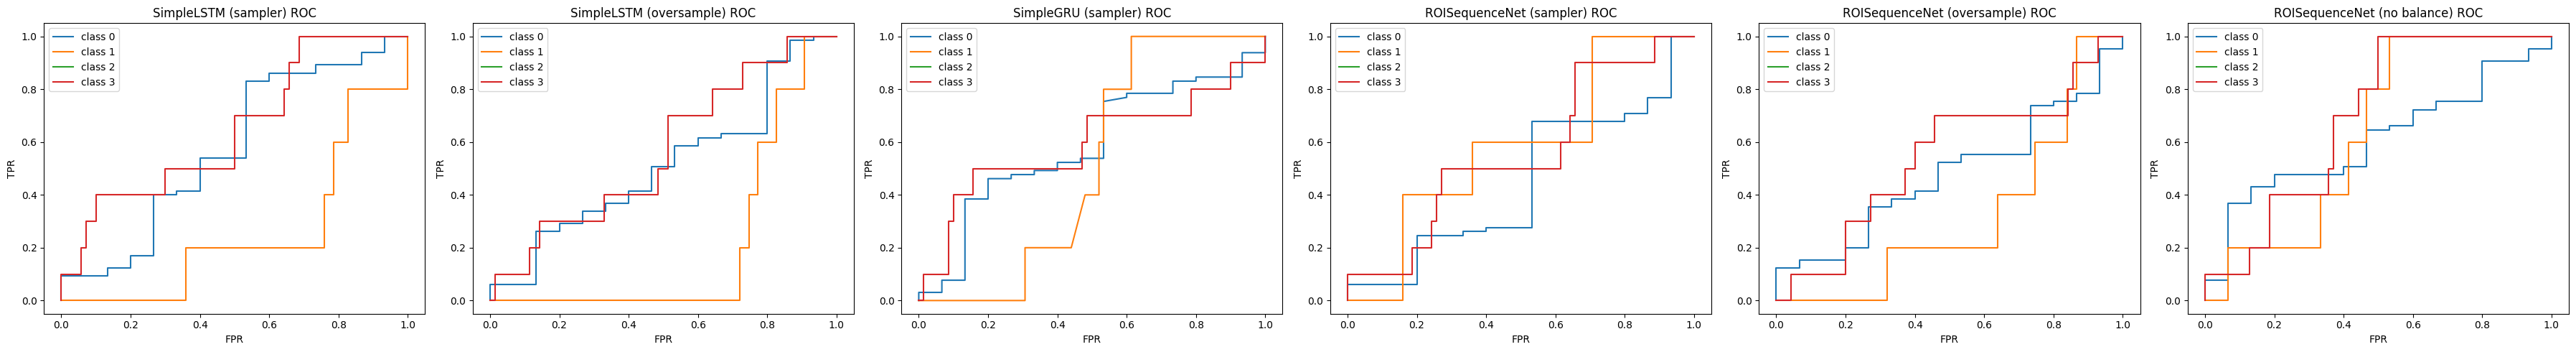


Сводная таблица финальных метрик:
                       model  val_acc  val_auc    val_f1
0         SimpleLSTM_sampler   0.4875      NaN  0.573594
1      SimpleLSTM_oversample   0.5625      NaN  0.610539
2          SimpleGRU_sampler   0.2500      NaN  0.292751
3     ROISequenceNet_sampler   0.7750      NaN  0.725893
4  ROISequenceNet_oversample   0.6625      NaN  0.657538
5   ROISequenceNet_nobalance   0.1250      NaN  0.027778

[INFO] Завершено: построение ROC (если было возможно), метрики, сохранение историй.


In [30]:
# === ROC Curves и сводные метрики (устойчиво к отсутствию oversample / других моделей) ===
from sklearn.preprocessing import label_binarize
try:
    roc_curve
except NameError:
    from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score
try:
    F
except NameError:
    import torch.nn.functional as F
import os

@torch.no_grad()
def collect_probs_and_labels(model, val_loader, device):
    model.eval(); all_probs=[]; all_labels=[]
    for batch in val_loader:
        if len(batch)==5: X,M,C,y,_ = batch
        elif len(batch)==4: X,M,C,y = batch
        elif len(batch)==3: X,C,y = batch; M=None
        else: raise ValueError("Unexpected batch format")
        X=X.to(device)
        M = M.to(device) if M is not None else None
        C = C.to(device) if (C is not None and C.nelement()>0) else None
        # Унификация вызова
        if M is None and C is None:
            out = model(X)
        else:
            # поддержка аргумента z vs cov
            try:
                out = model(X, mask=M, cov=C)
            except TypeError:
                out = model(X, mask=M, z=C)
        probs = F.softmax(out, dim=1).cpu().numpy()
        all_probs.append(probs); all_labels.extend(y.numpy())
    if not all_probs:
        return np.zeros((0, N_CLASSES)), np.zeros((0,), dtype=int)
    return np.vstack(all_probs), np.array(all_labels)

classes_sorted = sorted(cls_counts.index.tolist())
print('Classes:', classes_sorted)

# --- Подготовка oversample версии LSTM при отсутствии ---
if 'model_lstm_over' not in globals():
    orig_strategy = BALANCE_STRATEGY
    try:
        BALANCE_STRATEGY = 'oversample'
        train_dl_over, val_dl_over = make_fold_dataloaders(data_df, fold_idx=0, mode=DATA_MODE, cov_pipeline=pre)
        model_lstm_over = SimpleLSTM(n_rois=R, n_classes=N_CLASSES, cov_dim=cov_dim, hidden=64, num_layers=1).to(DEVICE)
        checkpoint_dir_path_lstm_over = f"{CHECKPOINT_DIR}/SimpleLSTM_oversample"
        os.makedirs(checkpoint_dir_path_lstm_over, exist_ok=True)
        history_lstm_oversample = train_model(
            model_lstm_over, train_dl_over, val_dl_over, cls_counts, DEVICE,
            epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_lstm_over,
            lr=LR, weight_decay=WEIGHT_DECAY, debug=False,
            early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE
        )
        hist_lstm_oversample_df = pd.DataFrame(history_lstm_oversample)
        best_path = os.path.join(checkpoint_dir_path_lstm_over, 'best_model.pth')
        if os.path.exists(best_path):
            model_lstm_over.load_state_dict(torch.load(best_path, map_location=DEVICE))
    except Exception as e:
        print(f"[WARN] Oversample LSTM preparation failed: {e}")
        model_lstm_over = None
        val_dl_over = None
        hist_lstm_oversample_df = None
    finally:
        BALANCE_STRATEGY = orig_strategy

# --- Сбор вероятностей (только для существующих моделей) ---
lstm_sampler_probs, lstm_sampler_labels = collect_probs_and_labels(model_lstm, val_dl, DEVICE)

lstm_over_probs, lstm_over_labels = (None, None)
if 'model_lstm_over' in globals() and model_lstm_over is not None and 'val_dl_over' in globals() and val_dl_over is not None:
    lstm_over_probs, lstm_over_labels = collect_probs_and_labels(model_lstm_over, val_dl_over, DEVICE)

gru_probs, gru_labels = (None, None)
if 'model_gru' in globals():
    gru_probs, gru_labels = collect_probs_and_labels(model_gru, val_dl, DEVICE)

roi_probs, roi_labels = (None, None)
if 'model_roi_seq_net' in globals():
    roi_probs, roi_labels = collect_probs_and_labels(model_roi_seq_net, val_dl, DEVICE)

roi_over_probs, roi_over_labels = (None, None)
if 'model_roi_seq_net_over' in globals() and model_roi_seq_net_over is not None and 'val_dl_over' in globals() and val_dl_over is not None:
    roi_over_probs, roi_over_labels = collect_probs_and_labels(model_roi_seq_net_over, val_dl_over, DEVICE)

roi_nb_probs, roi_nb_labels = (None, None)
if 'model_roi_seq_net_nb' in globals():
    roi_nb_probs, roi_nb_labels = collect_probs_and_labels(model_roi_seq_net_nb, val_dl_nb, DEVICE)

# --- Binarization helper (skip if probs is None) ---
def binarize(labels):
    if labels is None: return None
    return label_binarize(labels, classes=classes_sorted)

lstm_sampler_bin = binarize(lstm_sampler_labels)
lstm_over_bin    = binarize(lstm_over_labels)
gru_bin          = binarize(gru_labels)
roi_bin          = binarize(roi_labels)
roi_over_bin     = binarize(roi_over_labels)
roi_nb_bin       = binarize(roi_nb_labels)

# --- Подготовка списка для построения ROC ---
plot_items = []
if lstm_sampler_bin is not None:
    plot_items.append(('SimpleLSTM (sampler)', lstm_sampler_bin, lstm_sampler_probs))
if lstm_over_bin is not None:
    plot_items.append(('SimpleLSTM (oversample)', lstm_over_bin, lstm_over_probs))
if gru_bin is not None:
    plot_items.append(('SimpleGRU (sampler)', gru_bin, gru_probs))
if roi_bin is not None:
    plot_items.append(('ROISequenceNet (sampler)', roi_bin, roi_probs))
if roi_over_bin is not None:
    plot_items.append(('ROISequenceNet (oversample)', roi_over_bin, roi_over_probs))
if roi_nb_bin is not None:
    plot_items.append(('ROISequenceNet (no balance)', roi_nb_bin, roi_nb_probs))

if plot_items:
    fig, axes = plt.subplots(1, len(plot_items), figsize=(6*len(plot_items), 5))
    if len(plot_items) == 1:
        axes = [axes]
    for ax, (title, y_bin, probs) in zip(axes, plot_items):
        for c_idx, c_lab in enumerate(classes_sorted):
            try:
                fpr, tpr, _ = roc_curve(y_bin[:, c_idx], probs[:, c_idx])
                ax.plot(fpr, tpr, label=f'class {c_lab}')
            except Exception:
                pass
        ax.set_title(f'{title} ROC')
        ax.set_xlabel('FPR'); ax.set_ylabel('TPR'); ax.legend()
    plt.tight_layout(); plt.show()
else:
    print("[INFO] Нет моделей для построения ROC.")

# --- Сводная таблица метрик ---
summary_rows = []

def add_summary(name, probs, labels):
    if probs is None or labels is None:
        return
    try:
        preds = probs.argmax(1)
        acc = accuracy_score(labels, preds)
        try:
            auc = roc_auc_score(labels, probs, multi_class='ovr')
        except Exception:
            auc = float('nan')
        f1 = f1_score(labels, preds, average='weighted')
        summary_rows.append({'model': name, 'val_acc': acc, 'val_auc': auc, 'val_f1': f1})
    except Exception as e:
        print(f"[WARN] Summary failed for {name}: {e}")

add_summary('SimpleLSTM_sampler', lstm_sampler_probs, lstm_sampler_labels)
add_summary('SimpleLSTM_oversample', lstm_over_probs, lstm_over_labels)
add_summary('SimpleGRU_sampler', gru_probs, gru_labels)
add_summary('ROISequenceNet_sampler', roi_probs, roi_labels)
add_summary('ROISequenceNet_oversample', roi_over_probs, roi_over_labels)
add_summary('ROISequenceNet_nobalance', roi_nb_probs, roi_nb_labels)

summary_df = pd.DataFrame(summary_rows)
print('\nСводная таблица финальных метрик:')
print(summary_df if not summary_df.empty else '[EMPTY]')

# --- Сохранение историй (проверка наличия) ---
if 'hist_lstm_sampler_df' in globals():
    hist_lstm_sampler_df.to_csv(os.path.join(checkpoint_dir_path_lstm, 'history_sampler.csv'), index=False)
if 'hist_lstm_oversample_df' in globals() and hist_lstm_oversample_df is not None:
    hist_lstm_oversample_df.to_csv(os.path.join(checkpoint_dir_path_lstm_over, 'history_oversample.csv'), index=False)
if 'hist_gru_df' in globals():
    hist_gru_df.to_csv(os.path.join(checkpoint_dir_path_gru, 'history_sampler.csv'), index=False)
if 'hist_roi_seq_df' in globals():
    hist_roi_seq_df.to_csv(os.path.join(checkpoint_dir_path_roi_seq_net, 'history_sampler.csv'), index=False)
if 'hist_roi_seq_oversample_df' in globals():
    hist_roi_seq_oversample_df.to_csv(os.path.join(checkpoint_dir_path_roi_seq_net_over, 'history_oversample.csv'), index=False)
if 'hist_roi_seq_nobalance_df' in globals():
    hist_roi_seq_nobalance_df.to_csv(os.path.join(checkpoint_dir_path_roi_seq_net_nb, 'history_nobalance.csv'), index=False)

print('\n[INFO] Завершено: построение ROC (если было возможно), метрики, сохранение историй.')

## 9) Baseline A — Статический функциональный коннектом (FC) + логистическая регрессия
Идея: из каждого временного ряда NPY `(T,R)` считаем корреляционную матрицу `R×R` (Пирсон), применяем **Фишера z** и векторизуем верхний треугольник → получаем признак фиксированной длины. 
Затем обучаем **LogisticRegression (multinomial)**, опционально предваряя **PCA** до `FC_PCA_COMPONENTS`.
Разбиение — то же групповое (без утечек).

In [31]:
idx = np.arange(len(data_df))
gss = GroupShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=SEED)
train_idx, val_idx = next(gss.split(idx, groups=data_df['site_x'].values))
train_df, val_df = data_df.iloc[train_idx].reset_index(drop=True), data_df.iloc[val_idx].reset_index(drop=True)

print(f"train N={len(train_df)}, val N={len(val_df)}; groups → train:{train_df['site_x'].nunique()}, val:{val_df['site_x'].nunique()}")

train N=307, val N=65; groups → train:4, val:2


In [32]:
if RUN_BASELINES:
    def fisher_z(r):
        r = np.clip(r, -0.999999, 0.999999)
        return 0.5*np.log((1+r)/(1-r))

    def vec_uppertri(M):
        iu = np.triu_indices_from(M, k=1)
        return M[iu]

    def fc_vector_from_npy(path):
        X = np.load(path)  # (T,R)
        C = np.corrcoef(X, rowvar=False)
        # Replace NaNs arising from zero-variance ROI time series
        C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(C, 1.0)
        Cz = fisher_z(C)
        return vec_uppertri(Cz)

    def build_fc_matrix(df):
        feats = [fc_vector_from_npy(p) for p in df['npy_path']]
        X = np.vstack(feats)
        # Safety: ensure no NaNs remain
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        y = df['label'].values.astype(int)
        return X, y

    Xtr, ytr = build_fc_matrix(train_df)
    Xva, yva = build_fc_matrix(val_df)
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xtr_s = scaler.fit_transform(Xtr)
    Xva_s = scaler.transform(Xva)
    # Extra safety before PCA
    if np.isnan(Xtr_s).any() or np.isnan(Xva_s).any():
        Xtr_s = np.nan_to_num(Xtr_s, nan=0.0, posinf=0.0, neginf=0.0)
        Xva_s = np.nan_to_num(Xva_s, nan=0.0, posinf=0.0, neginf=0.0)
    
    if FC_PCA_COMPONENTS and FC_PCA_COMPONENTS > 0:
        # PCA ограничение: n_components <= min(n_samples, n_features)
        allowable = min(Xtr_s.shape[0], Xtr_s.shape[1])
        n_comp = min(FC_PCA_COMPONENTS, allowable)
        if n_comp < 1:
            print("Пропуск PCA: недостаточно допустимых компонент.")
        else:
            if n_comp != FC_PCA_COMPONENTS:
                print(f"Понижено число компонент PCA с {FC_PCA_COMPONENTS} до {n_comp} (min(n_samples={Xtr_s.shape[0]}, n_features={Xtr_s.shape[1]})).")
            pca = PCA(n_components=n_comp)
            Xtr_s = pca.fit_transform(Xtr_s)
            Xva_s = pca.transform(Xva_s)
    clf = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')
    clf.fit(Xtr_s, ytr)
    pr_tr = clf.predict_proba(Xtr_s); pr_va = clf.predict_proba(Xva_s)
    yh_va = pr_va.argmax(1)
    acc = accuracy_score(yva, yh_va)
    f1  = f1_score(yva, yh_va, average='macro')
    try:
        auc = roc_auc_score(yva, pr_va, multi_class='ovr', average='macro')
    except Exception:
        auc = float('nan')
    print(f"[FC-LogReg] val_acc={acc:.3f} | val_auc={auc:.3f} | val_f1={f1:.3f}")


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[FC-LogReg] val_acc=0.585 | val_auc=nan | val_f1=0.262


/usr/local/Caskroom/miniconda/base/envs/nlp312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## 10) Baseline B — Динамический FC + HMM-фичи (или KMeans fallback)
Идея: скользящим окном (`WIN_DYN`, шаг `STEP_DYN`) считаем FC по каждому окну → получаем последовательность векторов ("кадров") на субъекта. 
На **train** обучаем `GaussianHMM(n_states=HMM_N_STATES)` по этим кадрам. Для каждого субъекта считаем признаки:
- доля времени в каждом состоянии,
- частота переключений,
- средняя длительность посещений.
Если `hmmlearn` недоступен, используем **KMeans** как приближение скрытых состояний.
Классификатор: `LogisticRegression` на агрегированных признаках.

In [33]:
def sliding_windows(X, win=30, step=5):
    t, r = X.shape
    for s in range(0, max(1, t - win + 1), step):
        e = min(t, s + win)
        if e - s >= max(5, win//2):
            yield X[s:e]

def fc_frames_from_npy(path, win=30, step=5):
    X = np.load(path)
    frames = []
    for seg in sliding_windows(X, win, step):
        C = np.corrcoef(seg, rowvar=False)
        r = 0.5*np.log((1+np.clip(C, -0.999999, 0.999999))/(1-np.clip(C, -0.999999, 0.999999)))
        iu = np.triu_indices_from(r, k=1)
        frames.append(r[iu])
    if not frames:
        C = np.corrcoef(X, rowvar=False); iu = np.triu_indices_from(C, 1)
        r = 0.5*np.log((1+np.clip(C, -0.999999, 0.999999))/(1-np.clip(C, -0.999999, 0.999999)))
        frames = [r[iu]]
    return np.vstack(frames)

def summarize_states(states, n_states):
    T = len(states)
    if T == 0:
        return np.zeros(n_states + 2)
    frac = np.bincount(states, minlength=n_states) / max(1, T)
    switches = (states[1:] != states[:-1]).mean() if T>1 else 0.0
    lengths = []
    cur = 1
    for i in range(1, T):
        if states[i]==states[i-1]: cur += 1
        else: lengths.append(cur); cur = 1
    lengths.append(cur)
    dwell = float(np.mean(lengths))
    return np.concatenate([frac, [switches, dwell]])

In [ ]:
if RUN_BASELINES:
    # HAS_HMM флаг (модуль уже импортирован выше, просто оставим структуру)
    try:
        HAS_HMM = True  # По-умолчанию используем Hidden Markov Model
    except Exception:
        HAS_HMM = False

    # Получаем кадры динамического FC
    tr_frames = [fc_frames_from_npy(p, WIN_DYN, STEP_DYN) for p in train_df['npy_path']]
    va_frames = [fc_frames_from_npy(p, WIN_DYN, STEP_DYN) for p in val_df['npy_path']]

    # Санитизация (NaN / inf -> 0) для устойчивости HMM / KMeans
    def sanitize_frames(fr_list):
        return [np.nan_to_num(f, nan=0.0, posinf=0.0, neginf=0.0) for f in fr_list]

    tr_frames = sanitize_frames(tr_frames)
    va_frames = sanitize_frames(va_frames)

    # Объединяем обучающие кадры
    Xtrain_seq = np.vstack(tr_frames)
    Xtrain_seq = np.nan_to_num(Xtrain_seq, nan=0.0, posinf=0.0, neginf=0.0)

    # Удаляем/обрабатываем почти константные признаки (иначе ковариации нулевые -> ValueError)
    var = Xtrain_seq.var(axis=0)
    dyn_keep_cols = var > 1e-12
    if dyn_keep_cols.sum() < Xtrain_seq.shape[1]:
        removed = (~dyn_keep_cols).sum()
        print(f"[DynFC] Removed {removed} near-constant features before HMM/KMeans.")
        Xtrain_seq = Xtrain_seq[:, dyn_keep_cols]
    else:
        dyn_keep_cols = None  # ничего не удаляем

    # Лёгкая стабилизация: добавим eps к абсолютно нулевым столбцам (если остались)
    zero_var_cols = (Xtrain_seq.var(axis=0) <= 1e-12)
    if zero_var_cols.any():
        Xtrain_seq[:, zero_var_cols] += np.random.randn(Xtrain_seq.shape[0], zero_var_cols.sum()) * 1e-6
        print(f"[DynFC] Injected epsilon noise into {zero_var_cols.sum()} zero-variance columns.")

    n_states = int(HMM_N_STATES)

    def _apply_keep(frames):
        """
        Санитизация + приведение числа признаков к размеру dyn_keep_cols.
        Исправление IndexError при несовпадении длины boolean mask и числа колонок:
        - Если во входном кадре меньше признаков (из-за различного числа ROI после salvage),
          дополняем нулями.
        - Если больше — обрезаем.
        После выравнивания применяем dyn_keep_cols.
        """
        frames = np.nan_to_num(frames, nan=0.0, posinf=0.0, neginf=0.0)
        if dyn_keep_cols is not None:
            target_len = dyn_keep_cols.shape[0]
            cur_len = frames.shape[1]
            if cur_len != target_len:
                if cur_len < target_len:
                    # pad zeros to the right
                    pad = np.zeros((frames.shape[0], target_len - cur_len), dtype=frames.dtype)
                    frames = np.hstack([frames, pad])
                else:
                    # truncate extra columns
                    frames = frames[:, :target_len]
            # now safe to index
            frames = frames[:, dyn_keep_cols]
        return frames

    if HAS_HMM:
        model_states = GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=200, random_state=0)
        try:
            model_states.fit(Xtrain_seq)
        except ValueError as e:
            print(f"[DynFC-HMM] HMM fit failed ({e}) -> fallback to KMeans.")
            HAS_HMM = False

    if HAS_HMM:
        def assign_states(frames):
            frames = _apply_keep(frames)
            return model_states.predict(frames)
    else:
        # Fallback: KMeans
        kmeans = KMeans(n_clusters=n_states, random_state=0)
        kmeans.fit(Xtrain_seq)

        def assign_states(frames):
            frames = _apply_keep(frames)
            return kmeans.predict(frames)

[DynFC] Removed 703 near-constant features before HMM/KMeans.
[DynFC-HMM] HMM fit failed ('diag' covars must be positive) -> fallback to KMeans.


IndexError: boolean index did not match indexed array along dimension 1; dimension is 61425 but corresponding boolean dimension is 62128

In [42]:
if RUN_BASELINES:
    def _apply_keep(frames):
        """
        Санитизация + приведение числа признаков к размеру dyn_keep_cols.
        Исправление IndexError при несовпадении длины boolean mask и числа колонок:
        - Если во входном кадре меньше признаков (из-за различного числа ROI после salvage),
          дополняем нулями.
        - Если больше — обрезаем.
        После выравнивания применяем dyn_keep_cols.
        """
        frames = np.nan_to_num(frames, nan=0.0, posinf=0.0, neginf=0.0)
        if dyn_keep_cols is not None:
            target_len = dyn_keep_cols.shape[0]
            cur_len = frames.shape[1]
            if cur_len != target_len:
                if cur_len < target_len:
                    # pad zeros to the right
                    pad = np.zeros((frames.shape[0], target_len - cur_len), dtype=frames.dtype)
                    frames = np.hstack([frames, pad])
                else:
                    # truncate extra columns
                    frames = frames[:, :target_len]
            # now safe to index
            frames = frames[:, dyn_keep_cols]
        return frames

    def build_dyn_feats(frames_list):
        feats = []
        for fr in frames_list:
            fr_san = _apply_keep(fr)
            st = assign_states(fr_san)
            feats.append(summarize_states(st, n_states))
        return np.vstack(feats)

    # Строим агрегированные признаки состояний
    Xtr = build_dyn_feats(tr_frames)
    ytr = train_df['label'].values.astype(int)
    Xva = build_dyn_feats(va_frames)
    yva = val_df['label'].values.astype(int)

    # Финальная модель
    clf = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')
    clf.fit(Xtr, ytr)

    pr_va = clf.predict_proba(Xva)
    yh_va = pr_va.argmax(1)
    acc = accuracy_score(yva, yh_va)
    f1 = f1_score(yva, yh_va, average='macro')
    try:
        auc = roc_auc_score(yva, pr_va, multi_class='ovr', average='macro')
    except Exception:
        auc = float('nan')
    print(f"[DynFC-HMM] val_acc={acc:.3f} | val_auc={auc:.3f} | val_f1={f1:.3f} | HAS_HMM={HAS_HMM}")


[DynFC-HMM] val_acc=0.523 | val_auc=nan | val_f1=0.172 | HAS_HMM=False


## 11) Оценка переносимости: Leave-One-Site-Out (LOSO) для FC-baseline
Для каждого сайта извлекаем его как **валидационную** выборку, обучаемся на остальных и считаем метрики. Это имитирует перенос на новый центр/сканер.

In [37]:
def fisher_z(r):
    r = np.clip(r, -0.999999, 0.999999)
    return 0.5*np.log((1+r)/(1-r))

def vec_uppertri(M):
    iu = np.triu_indices_from(M, k=1)
    return M[iu]

def fc_vector_from_npy(path):
    X = np.load(path)
    C = np.corrcoef(X, rowvar=False)
    Cz = fisher_z(C)
    return vec_uppertri(Cz)

def build_fc_matrix(df):
    feats = [fc_vector_from_npy(p) for p in df['npy_path']]
    X = np.vstack(feats)
    y = df['label'].values.astype(int)
    return X, y

def pid2site(pid):
    s = pid.replace('sub-','')
    m = re.match(r'([a-z]+)', s)
    return m.group(1) if m else 'na'

In [38]:
if RUN_BASELINES and DO_LOSO:
    sites = sorted({pid2site(pid) for pid in data_df['participant_id']})
    res = []
    for site in sites:
        tr_idx = data_df['participant_id'].map(pid2site) != site
        va_idx = ~tr_idx
        tr_df = data_df[tr_idx].reset_index(drop=True)
        va_df = data_df[va_idx].reset_index(drop=True)
        if len(va_df) < 5 or len(tr_df) < 10:
            print(f"[LOSO:{site}] слишком мало данных — пропуск")
            continue
        # Формирование признаков (могут содержать NaN из-за нулевой дисперсии ROI)
        Xtr, ytr = build_fc_matrix(tr_df)
        Xva, yva = build_fc_matrix(va_df)
        # Заменяем NaN / inf значениями 0 перед любыми трансформациями
        Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)
        Xva = np.nan_to_num(Xva, nan=0.0, posinf=0.0, neginf=0.0)
        # Масштабирование
        scaler = StandardScaler()
        Xtr_s = scaler.fit_transform(Xtr)
        Xva_s = scaler.transform(Xva)
        # Повторная санитаризация (иногда стандартизация может породить inf при нулевом std)
        Xtr_s = np.nan_to_num(Xtr_s, nan=0.0, posinf=0.0, neginf=0.0)
        Xva_s = np.nan_to_num(Xva_s, nan=0.0, posinf=0.0, neginf=0.0)
        # PCA (с проверкой допустимого числа компонент и отсутствия NaN)
        if FC_PCA_COMPONENTS and FC_PCA_COMPONENTS > 0:
            allowable = min(Xtr_s.shape[0], Xtr_s.shape[1])
            n_comp = min(FC_PCA_COMPONENTS, allowable)
            if n_comp < 1:
                print(f"[LOSO:{site}] Пропуск PCA (недостаточно компонент).")
            else:
                if n_comp != FC_PCA_COMPONENTS:
                    print(f"[LOSO:{site}] PCA компонентов снижено до {n_comp} (allowable={allowable}).")
                # Санитизация перед PCA fit
                Xtr_s = np.nan_to_num(Xtr_s, nan=0.0, posinf=0.0, neginf=0.0)
                Xva_s = np.nan_to_num(Xva_s, nan=0.0, posinf=0.0, neginf=0.0)
                try:
                    pca = PCA(n_components=n_comp)
                    Xtr_s = pca.fit_transform(Xtr_s)
                    Xva_s = pca.transform(Xva_s)
                    # Финальная санитаризация
                    Xtr_s = np.nan_to_num(Xtr_s, nan=0.0, posinf=0.0, neginf=0.0)
                    Xva_s = np.nan_to_num(Xva_s, nan=0.0, posinf=0.0, neginf=0.0)
                except ValueError as e:
                    print(f"[LOSO:{site}] Пропуск PCA из-за ошибки: {e}")
        # Обучение логистической регрессии
        clf = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')
        clf.fit(Xtr_s, ytr)
        pr = clf.predict_proba(Xva_s); yh = pr.argmax(1)
        acc = accuracy_score(yva, yh)
        f1  = f1_score(yva, yh, average='macro')
        try:
            auc = roc_auc_score(yva, pr, multi_class='ovr', average='macro')
        except Exception:
            auc = float('nan')
        res.append({"site": site, "N_val": len(va_df), "acc":acc, "auc":auc, "f1":f1})
        print(f"[LOSO:{site}] N={len(va_df)} | acc={acc:.3f} | auc={auc:.3f} | f1={f1:.3f}")
    if res:
        df_res = pd.DataFrame(res)
        display(df_res)
        print("Средние по сайтам:", df_res[['acc','auc','f1']].mean().to_dict())


[LOSO:kki] N=9 | acc=0.556 | auc=nan | f1=0.192
[LOSO:neuroimage] N=56 | acc=0.554 | auc=0.684 | f1=0.317
[LOSO:nyu] N=127 | acc=0.520 | auc=nan | f1=0.207
[LOSO:peking] N=92 | acc=0.696 | auc=nan | f1=0.492
[LOSO:pittsburgh] N=36 | acc=0.750 | auc=nan | f1=0.286
[LOSO:washu] N=52 | acc=0.731 | auc=nan | f1=0.281


,site,N_val,acc,auc,f1
0,kki,9,0.555556,NaN,0.192308
1,neuroimage,56,0.553571,0.683831,0.317409
2,nyu,127,0.519685,NaN,0.206910
3,peking,92,0.695652,NaN,0.492492
4,pittsburgh,36,0.750000,NaN,0.285714
5,washu,52,0.730769,NaN,0.281481


Средние по сайтам: {'acc': 0.6342055713632229, 'auc': 0.6838305461073318, 'f1': 0.2960525144200667}


In [53]:
%pip install xlwt
%pip install openpyxl

import xlwt
import pandas as pd
from pathlib import Path

rows = [
    ["Отбор данных","ADHD200; когорты 12–15 и 16–21; унификация ID; контроль утечки (splits по participant_id)",
     "Фенотипы (CSV), фильтры по возрасту, групповые сплиты по participant_id","Сделано"],
    ["Подготовка сигналов","ROI-тайм-серии Athena; окна фикс. длины T_FIX; mask паддинга; TR из BIDS",
     ".npy/.tsv.gz (T×R), *_mask.npy, *_bold.json","Сделано"],
    ["Базовые признаки","Статическая FC из окна (Fisher-z верхний треугольник)",
     "Внутренняя функция расчёта FC; baseline","Сделано"],
    ["Ковариаты","Age / Gender / Site (предобработка и добавление в модель)",
     "ColumnTransformer: StandardScaler + OneHotEncoder (fit на train)","Сделано"],
    ["Модели (последоват.)","LSTM, GRU на (T, R) с поддержкой mask (зануление/pack)",
     "PyTorch DataLoader (B, T, R)","Сделано"],
    ["Основная модель","ROISequenceNet: Conv1d по времени per-ROI + Self-Attention по ROI + классификация",
     "PyTorch; вход (T, R); mask учитывается","Сделано"],
    ["Бейзлайн (классика)","LogisticRegression на статической FC","scikit-learn","Сделано"],
    ["Валидация и метрики","StratifiedGroupKFold / GroupShuffleSplit по participant_id; Accuracy/Precision/F1/AUC",
     "sklearn.metrics; логирование результатов","Сделано (нестабильность из-за объёма)"],
    ["Гармонизация по сайту","Коррекция межсайтовых сдвигов (ComBat)","neuroComBat/аналог","План"],
    ["Motion-QC","FD/DVARS как ковариаты/фильтр; скраббинг","Конфаунды из fMRIPrep/Athena","План"],
    ["dFC-признаки","Окна → FC-векторы → k-means состояния → occupancy/transition/dwell",
     "DFC_CSV + MLP/ROISequenceNet","План"],
    ["Последовательность окон","TCN/Transformer «по окнам» (моделирование переходов состояний)",
     "PyTorch (вторая ось времени: окно→окно)","План"],
    ["Интерпретация","Пермутационные важности, Integrated Gradients, карты внимания",
     "Captum/собственные процедуры","План"],
    ["Воспроизводимость","2 ноутбука: (1) подготовка/QC, (2) обучение/оценка; фиксация seed/версий",
     "Версионирование манифеста/парцелляций/конфигов","Сделано"],
]

df = pd.DataFrame(rows, columns=["Этап","Метод / данные","Инструменты и артефакты","Статус"])

out_xls  = Path("methodology_ADHD200.xls")
out_xlsx = Path("methodology_ADHD200.xlsx")
out_csv  = Path("methodology_ADHD200.csv")

saved = None
try:
    df.to_excel(out_xls, index=False)      # требует пакет xlwt для .xls
    saved = out_xls
except Exception:
    df.to_excel(out_xlsx, index=False)     # универсальный .xlsx (требует openpyxl)
    saved = out_xlsx

df.to_csv(out_csv, index=False)

print("Saved Excel to:", saved.resolve())
print("Also CSV:", out_csv.resolve())

python(87571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


python(87635) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.
Saved Excel to: /Users/alexey.stafeev/Documents/!Documents/Магистратура_МФТИ/Предметы/НИР/Материалы/ADHD200/Athena/methodology_ADHD200.xls
Also CSV: /Users/alexey.stafeev/Documents/!Documents/Магистратура_МФТИ/Предметы/НИР/Материалы/ADHD200/Athena/methodology_ADHD200.csv
